<a href="https://colab.research.google.com/github/Kcurr01/HUT_Research/blob/main/S2_Captum_Optuna_VAE_3_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Instalation 
---

In [46]:
# !pip install captum
# !pip install umap-learn
# !pip install datashader
# !pip install bokeh
# !pip install holoviews
!pip install tensorboardX
!pip install optuna
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
VAE Experiment 1 **[]** 2/27
---

In [101]:
import torch   
import torch.nn as nn                          
import torch.nn.functional as F                
import torch.optim as optim   
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data

import pandas as pd 
import numpy as np
import os                             

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns    

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

import torchvision
from torchvision import datasets

#based on sensor data can you determine the stimulus that is currently in use?
import optuna
from optuna.pruners import ThresholdPruner
from optuna import TrialPruned

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [102]:
df = pd.read_csv("/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/Subject_Experiment_1/S2_E1_A1.csv")
#drops all 0 labels (no label)
indices_to_drop = df[df["stimulus"] == 0].index
df.drop(indices_to_drop, inplace=True)

#Removes number of features from data
# df.drop('Cyber Glove (angles of the joints) Sensor 1', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 2', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 3', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 4', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 5', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 6', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 7', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 8', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 9', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 10', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 11', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 12', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 13', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 14', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 15', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 16', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 17', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 18', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 19', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 20', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 21', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 22', inplace=True, axis=1)

In [103]:
df.head()

,stimulus,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
862,1,-0.03418,0.84131,-0.51855,0,-1,-1,0,0,0,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
863,1,-0.03418,0.84131,-0.51855,0,0,-2,-2,-2,0,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
864,1,-0.03418,0.84131,-0.51855,-1,0,-1,-2,-1,-2,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
865,1,-0.03418,0.84131,-0.51855,-4,-5,-5,-1,0,-1,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
866,1,-0.03418,0.84131,-0.51855,0,-2,-1,-1,-1,-1,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553


In [104]:
X = df.drop('stimulus', axis=1)
#y = df['stimulus']
y = df.iloc[:, 0:1]
print(X.shape, type(X), y.shape, type(y))
print()

(90015, 41) <class 'pandas.core.frame.DataFrame'> (90015, 1) <class 'pandas.core.frame.DataFrame'>



In [105]:
X.head()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
862,-0.03418,0.84131,-0.51855,0,-1,-1,0,0,0,-1,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
863,-0.03418,0.84131,-0.51855,0,0,-2,-2,-2,0,1,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
864,-0.03418,0.84131,-0.51855,-1,0,-1,-2,-1,-2,0,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
865,-0.03418,0.84131,-0.51855,-4,-5,-5,-1,0,-1,-1,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553
866,-0.03418,0.84131,-0.51855,0,-2,-1,-1,-1,-1,-2,...,67.71,-25.952,2.4988,49.344,63.171,-3.4729,15.409,21.185,-3.1765,13.553


---
Visualization number of labels

stimulus
10          7931
6           7619
8           7580
7           7567
5           7564
11          7539
4           7473
3           7424
9           7397
12          7357
2           7329
1           7235
dtype: int64

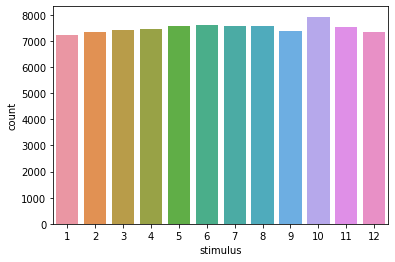

In [106]:
sns.countplot(x = 'stimulus', data=df)
y.value_counts()

---
Fixing Data Imbalance via Undersampling

<Axes: xlabel='stimulus'>

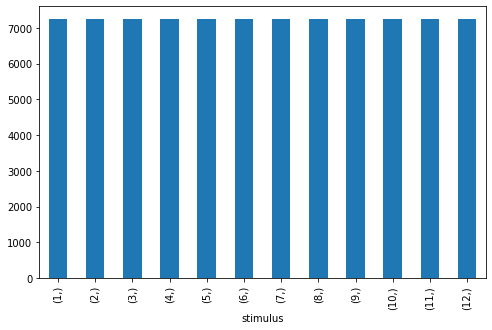

In [107]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = "not minority"
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
y_res.value_counts().plot(kind='bar', figsize=(8,5))

In [108]:
print(y_res.value_counts())
print(len(X_res.value_counts()))

stimulus
1           7235
2           7235
3           7235
4           7235
5           7235
6           7235
7           7235
8           7235
9           7235
10          7235
11          7235
12          7235
dtype: int64
86820


In [109]:
print(y)

        stimulus
862            1
863            1
864            1
865            1
866            1
...          ...
148362        12
148363        12
148364        12
148365        12
148366        12

[90015 rows x 1 columns]


---
Visualization of Data Distributions

In [110]:
# #distribution of first 19 features


# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(40, 40))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   print(f"[{index +1}] Updating plot")
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 20:
#     break 
# plt.tight_layout()

---
Defining Hyperparmaeters

In [111]:
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

#Hyperparameters
emg_channels = 16
imu_channels = 3

latent_dim = 2
input_dim= len(X.columns)

hidden_dim= round(input_dim/2)
hidden_dim_2 = round(input_dim/4)
output_dim = len(X.columns)
num_classes = 12
num_layers = round(num_classes/2)
tempature = 1

num_epochs= 10
batch_size= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0


alpha = 2        # Reconstruction Loss
beta = 2         # Kl Divergence Loss
gamma = 3        # Classifcation Loss
delta = 5        # Contrastive Loss
epsilon = 3      # Triplet Loss

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train Test Split

In [112]:
X = X_res.values
y = y_res.values
print(X.shape, type(X), y.shape, type(y))
print()

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train size: {len(X_train)} | X_val size: {len(X_val)} | X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)} | y_val size: {len(y_val)} | y_test size: {len(y_test)}")
print()
print(f"Training Feature Split: {X_train.shape} | Training Labels { y_train.shape}")
print(f"Validation Feature Split: {X_val.shape} | Validation Labels { y_val.shape}")
print(f"Testing Feature Split: {X_test.shape} | Testing Labels { y_test.shape}")
print()

(86820, 41) <class 'numpy.ndarray'> (86820, 1) <class 'numpy.ndarray'>

X_train size: 52092 | X_val size: 17364 | X_test size: 17364
y_train size: 52092 | y_val size: 17364 | y_test size: 17364

Training Feature Split: (52092, 41) | Training Labels (52092, 1)
Validation Feature Split: (17364, 41) | Validation Labels (17364, 1)
Testing Feature Split: (17364, 41) | Testing Labels (17364, 1)



---
Scaling/Normalizing Data

In [113]:
#Normalization Data 

#No Normalization 
# X_train_Normalized = X_train
# X_val_Normalized = X_val
# X_test_Normalized = X_test
#----------------------------------------------------------------------------------------------------------
# Minmax without preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train)
# X_val_Normalized = Minmax.transform(X_val)
# X_test_Normalized = Minmax.transform(X_test)
#----------------------------------------------------------------------------------------------------------
# Minmax with preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train_preprocessed)
# X_val_Normalized = Minmax.transform(X_val_preprocessed)
# X_test_Normalized = Minmax.transform(X_test_preprocessed)

#----------------------------------------------------------------------------------------------------------
# # Standardization without preprocessing
Standardized = preprocessing.StandardScaler()
X_train_Normalized= Standardized.fit_transform(X_train)
X_val_Normalized = Standardized.transform(X_val)
X_test_Normalized = Standardized.transform(X_test)

# Standardization with preprocessing
# Standardized = preprocessing.StandardScaler()
# X_train_Normalized= Standardized.fit_transform(X_train_preprocessed)
# X_val_Normalized = Standardized.transform(X_val_preprocessed)
# X_test_Normalized = Standardized.transform(X_test_preprocessed)
#----------------------------------------------------------------------------------------------------------

#Convert to numpy then to torch 

X_train = torch.from_numpy(X_train_Normalized).float()
y_train = torch.from_numpy(y_train).long()

X_val = torch.from_numpy(X_val_Normalized).float()
y_val = torch.from_numpy(y_val).long()

X_test = torch.from_numpy(X_test_Normalized).float()
y_test = torch.from_numpy(y_test).long()

print(f"X_train: {type(X_train)} | y_train {type(y_train)}")
print(f"X_val: {type(X_val)} | y_train {type(y_val)}")
print(f"X_test: {type(X_test)} | y_test {type(y_test)}")
print()
print(f"Training: {X_train.shape} , { y_train.shape}")
print(f"Validation: {X_val.shape} , { y_val.shape}")
print(f"Testing:  {X_test.shape} , { y_test.shape}")

X_train: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_val: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_test: <class 'torch.Tensor'> | y_test <class 'torch.Tensor'>

Training: torch.Size([52092, 41]) , torch.Size([52092, 1])
Validation: torch.Size([17364, 41]) , torch.Size([17364, 1])
Testing:  torch.Size([17364, 41]) , torch.Size([17364, 1])


---
Defining Dataloaders


In [114]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [115]:
training = ClassifierDataset(X_train, y_train)
validating = ClassifierDataset(X_val, y_val)
testing = ClassifierDataset(X_test, y_test)


train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

def get_data_loader(optuna_batch_size):
  train_loader = DataLoader(training, batch_size=optuna_batch_size, shuffle=True)
  val_loader = DataLoader(validating, batch_size=optuna_batch_size, shuffle=False)
  test_loader = DataLoader(testing, batch_size=optuna_batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

---
Defining VAE Model, Loss and Optmizers

In [116]:
class VAE(nn.Module):  
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()  
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.ReLU(),
        nn.Linear(num_layers, 13),
        nn.Softmax(dim=1)
    )

  def encode(self, x):  
    z = self.encoder(x)
    z1 = self.mu(z)               
    z2 = self.logvar(z) 
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)   

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)
    classified = classified / tempature

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")
  
  print(f"Logvar: {logvar.shape}")
 
  print(f"Latent Space Z: {z_reparmeterized.shape}")
 
  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([100, 41])
Mu: torch.Size([100, 2]) 
Logvar: torch.Size([100, 2])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 13])


In [117]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss

In [118]:
def train_VAE(trial, model, train_loader, val_loader, optimizer, epoch,alpha,beta,gamma, delta):
  train_losses=[]
  train_accuracy = []
  accuracy_log = []
  val_losses=[]
  val_accuracy=[]

  recon_loss_fn = nn.MSELoss(reduction="sum")
  classifier_loss_fn = nn.CrossEntropyLoss()
  contrastive_loss_fn = ContrastiveLoss(margin=1)

  train_running_loss = 0
  model.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = recon_loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

  
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + (delta*contrastive_loss)

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = recon_loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  trial.report(train_acc, epoch)
  if trial.should_prune():
      raise optuna.TrialPruned()

  return train_losses, val_losses, train_acc, val_acc



In [119]:
def objective(trial):
  params = {
          'optuna_batch_size' : trial.suggest_int('optuna_batch_size', 1e2, 1e3),
          'num_epochs' : num_epochs,
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
          "lr": trial.suggest_float('lr', 1e-4, 1e-2),
          "hidden_dim": trial.suggest_int('hidden_dim', 1e2, 1e3),
          'alpha': trial.suggest_int('alpha', 1e-1, 1e1),
          'beta': trial.suggest_int('beta', 1e-1, 1e1), 
          'gamma': trial.suggest_int('gamma', 1e-1, 1e1), 
          'delta': trial.suggest_int('delta', 1e-1, 1e1),        
  }

  train_loader, val_loader, test_loader = get_data_loader(params['optuna_batch_size'])
  model  = VAE(input_dim, params['hidden_dim'], latent_dim).to(device)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

  for epoch in range(params['num_epochs']):
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta)
  return train_acc


In [120]:
sampler = optuna.samplers.TPESampler()    
study = optuna.create_study(
    sampler=sampler,
    pruner=ThresholdPruner(lower=0.3, n_warmup_steps=3, interval_steps=1),
    direction='maximize')
study.optimize(func=objective, n_trials=200)

[I 2023-03-17 20:23:19,539] A new study created in memory with name: no-name-6e00680a-8b86-4392-a0e7-1f67ad049aaf


Epoch: 1 / 10 | Reconst_loss: 35547.930 | Kldiv loss: 25666.193 | Classifcation loss: 2.559 | Constrast loss: 14863.19 | Total loss: 1636107.625 | Train acc: 9.262 % ||| Val Loss: 201358.089 | Val acc: 9.048 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 32104.930 | Kldiv loss: 21017.811 | Classifcation loss: 2.512 | Constrast loss: 8493.72 | Total loss: 165778.156 | Train acc: 13.600 % ||| Val Loss: 147193.201 | Val acc: 15.492 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 10 | Reconst_loss: 27014.719 | Kldiv loss: 17795.244 | Classifcation loss: 2.477 | Constrast loss: 7142.07 | Total loss: 136603.591 | Train acc: 15.858 % ||| Val Loss: 129191.270 | Val acc: 17.732 %
------

[I 2023-03-17 20:24:20,007] Trial 0 pruned. 


Epoch: 4 / 10 | Reconst_loss: 26234.830 | Kldiv loss: 15974.160 | Classifcation loss: 2.454 | Constrast loss: 6478.10 | Total loss: 124482.962 | Train acc: 20.764 % ||| Val Loss: 120230.943 | Val acc: 24.613 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5682.289 | Kldiv loss: 1934.196 | Classifcation loss: 2.409 | Constrast loss: 146.25 | Total loss: 106902.408 | Train acc: 17.322 % ||| Val Loss: 49791.257 | Val acc: 31.023 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5142.275 | Kldiv loss: 1819.410 | Classifcation loss: 2.270 | Constrast loss: 143.85 | Total loss: 47111.493 | Train acc: 40.779 % ||| Val Loss: 49136.055 | Val acc: 45.418 %
---------------

[I 2023-03-17 20:27:10,309] Trial 1 finished with value: 0.6045867546103116 and parameters: {'optuna_batch_size': 552, 'optimizer': 'Adam', 'lr': 0.006252655488731555, 'hidden_dim': 923, 'alpha': 3, 'beta': 9, 'gamma': 1, 'delta': 0}. Best is trial 1 with value: 0.6045867546103116.


Epoch: 10 / 10 | Reconst_loss: 4341.068 | Kldiv loss: 1482.443 | Classifcation loss: 2.089 | Constrast loss: 39.86 | Total loss: 32476.396 | Train acc: 60.459 % ||| Val Loss: 31917.439 | Val acc: 59.973 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 285.632 | Kldiv loss: 103.129 | Classifcation loss: 2.284 | Constrast loss: 3.16 | Total loss: 83138410208.418 | Train acc: 26.585 % ||| Val Loss: 14468.915 | Val acc: 40.673 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 360.006 | Kldiv loss: 60.441 | Classifcation loss: 2.168 | Constrast loss: 5.29 | Total loss: 13286.499 | Train acc: 48.214 % ||| Val Loss: 12499.096 | Val acc: 51.932 %
------------------------

[I 2023-03-17 20:30:21,988] Trial 2 finished with value: 0.6869736640636968 and parameters: {'optuna_batch_size': 168, 'optimizer': 'Adam', 'lr': 0.008190457338124586, 'hidden_dim': 693, 'alpha': 8, 'beta': 0, 'gamma': 8, 'delta': 3}. Best is trial 2 with value: 0.6869736640636968.


Epoch: 10 / 10 | Reconst_loss: 168.077 | Kldiv loss: 87.662 | Classifcation loss: 1.858 | Constrast loss: 0.00 | Total loss: 9854.334 | Train acc: 68.697 % ||| Val Loss: 10112.654 | Val acc: 67.128 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2462.615 | Kldiv loss: 3655.927 | Classifcation loss: 2.526 | Constrast loss: 187.49 | Total loss: 2402140.208 | Train acc: 12.125 % ||| Val Loss: 393040.869 | Val acc: 17.363 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2834.501 | Kldiv loss: 3711.893 | Classifcation loss: 2.516 | Constrast loss: 230.05 | Total loss: 391270.673 | Train acc: 16.986 % ||| Val Loss: 371227.208 | Val acc: 21.056 %
---------------------

[I 2023-03-17 20:30:48,348] Trial 3 pruned. 


Epoch: 4 / 10 | Reconst_loss: 1894.922 | Kldiv loss: 2890.738 | Classifcation loss: 2.456 | Constrast loss: 147.01 | Total loss: 356337.110 | Train acc: 25.450 % ||| Val Loss: 332769.060 | Val acc: 25.501 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1528.139 | Kldiv loss: 289.724 | Classifcation loss: 2.191 | Constrast loss: 43.73 | Total loss: 20646.131 | Train acc: 37.137 % ||| Val Loss: 15988.618 | Val acc: 55.919 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1445.100 | Kldiv loss: 348.535 | Classifcation loss: 2.062 | Constrast loss: 22.30 | Total loss: 13697.290 | Train acc: 63.983 % ||| Val Loss: 13094.696 | Val acc: 66.599 %
-----------------------

[I 2023-03-17 20:35:15,339] Trial 4 finished with value: 0.7131958915654838 and parameters: {'optuna_batch_size': 215, 'optimizer': 'Adam', 'lr': 0.007154603436117007, 'hidden_dim': 948, 'alpha': 4, 'beta': 7, 'gamma': 2, 'delta': 3}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 1331.372 | Kldiv loss: 371.526 | Classifcation loss: 1.911 | Constrast loss: 13.51 | Total loss: 11371.686 | Train acc: 71.320 % ||| Val Loss: 11761.021 | Val acc: 71.760 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 28237.777 | Kldiv loss: 35868.309 | Classifcation loss: 2.548 | Constrast loss: 7100.82 | Total loss: 275638082.102 | Train acc: 9.600 % ||| Val Loss: 210582.904 | Val acc: 11.355 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 26707.006 | Kldiv loss: 11474.883 | Classifcation loss: 2.454 | Constrast loss: 2808.83 | Total loss: 152421.654 | Train acc: 18.516 % ||| Val Loss: 115082.715 | Val acc: 23.662 %
----------

[I 2023-03-17 20:37:37,329] Trial 5 finished with value: 0.5337323376101555 and parameters: {'optuna_batch_size': 951, 'optimizer': 'Adam', 'lr': 0.007782231575807794, 'hidden_dim': 888, 'alpha': 7, 'beta': 6, 'gamma': 9, 'delta': 9}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 17562.266 | Kldiv loss: 7206.513 | Classifcation loss: 2.183 | Constrast loss: 1706.17 | Total loss: 78932.837 | Train acc: 53.373 % ||| Val Loss: 75369.325 | Val acc: 54.372 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.130 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------

[I 2023-03-17 20:38:20,481] Trial 6 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.266 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:39:01,394] Trial 7 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.071 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:39:58,758] Trial 8 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.065 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:41:36,138] Trial 9 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 942.751 | Kldiv loss: 474.864 | Classifcation loss: 2.550 | Constrast loss: 12.90 | Total loss: 190210.396 | Train acc: 9.009 % ||| Val Loss: 50722.306 | Val acc: 13.971 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 938.161 | Kldiv loss: 396.792 | Classifcation loss: 2.495 | Constrast loss: 13.90 | Total loss: 45854.459 | Train acc: 18.413 % ||| Val Loss: 41907.498 | Val acc: 20.159 %
--------------------------------------------------------

[I 2023-03-17 20:41:49,931] Trial 10 pruned. 


Epoch: 4 / 10 | Reconst_loss: 987.531 | Kldiv loss: 361.944 | Classifcation loss: 2.522 | Constrast loss: 7.13 | Total loss: 35286.012 | Train acc: 24.465 % ||| Val Loss: 33515.779 | Val acc: 25.338 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1617.354 | Kldiv loss: 479.351 | Classifcation loss: 2.229 | Constrast loss: 69.29 | Total loss: 9788.700 | Train acc: 37.411 % ||| Val Loss: 6639.355 | Val acc: 51.270 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1793.162 | Kldiv loss: 450.478 | Classifcation loss: 1.973 | Constrast loss: 44.99 | Total loss: 6404.075 | Train acc: 59.527 % ||| Val Loss: 6214.822 | Val acc: 63.325 %
---------------------------------

[I 2023-03-17 20:44:31,298] Trial 11 finished with value: 0.6771793577311809 and parameters: {'optuna_batch_size': 103, 'optimizer': 'Adam', 'lr': 0.00949614672807259, 'hidden_dim': 476, 'alpha': 10, 'beta': 0, 'gamma': 6, 'delta': 3}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 1411.620 | Kldiv loss: 420.770 | Classifcation loss: 1.993 | Constrast loss: 10.40 | Total loss: 5636.125 | Train acc: 67.718 % ||| Val Loss: 5836.808 | Val acc: 67.269 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1907.563 | Kldiv loss: 826.910 | Classifcation loss: 2.368 | Constrast loss: 32.48 | Total loss: 14310956.347 | Train acc: 14.886 % ||| Val Loss: 49296.767 | Val acc: 27.833 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1487.601 | Kldiv loss: 617.212 | Classifcation loss: 2.233 | Constrast loss: 20.30 | Total loss: 43178.443 | Train acc: 35.789 % ||| Val Loss: 38271.963 | Val acc: 41.273 %
-------------------------

[I 2023-03-17 20:45:29,489] Trial 12 finished with value: 0.6606744778371627 and parameters: {'optuna_batch_size': 413, 'optimizer': 'Adam', 'lr': 0.007802548579361315, 'hidden_dim': 406, 'alpha': 5, 'beta': 3, 'gamma': 10, 'delta': 3}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 1312.489 | Kldiv loss: 481.771 | Classifcation loss: 2.062 | Constrast loss: 6.12 | Total loss: 27844.216 | Train acc: 66.067 % ||| Val Loss: 26646.497 | Val acc: 68.209 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 20723.350 | Kldiv loss: 7454.869 | Classifcation loss: 2.441 | Constrast loss: 3096.41 | Total loss: 215304.080 | Train acc: 14.421 % ||| Val Loss: 73712.544 | Val acc: 20.813 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 15021.385 | Kldiv loss: 4979.260 | Classifcation loss: 2.257 | Constrast loss: 1237.36 | Total loss: 58743.834 | Train acc: 38.534 % ||| Val Loss: 48030.635 | Val acc: 47.668 %
------------------

[I 2023-03-17 20:47:03,551] Trial 13 finished with value: 0.5849174743306785 and parameters: {'optuna_batch_size': 613, 'optimizer': 'Adam', 'lr': 0.009810323166536693, 'hidden_dim': 641, 'alpha': 2, 'beta': 4, 'gamma': 5, 'delta': 5}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 12517.950 | Kldiv loss: 4105.121 | Classifcation loss: 2.069 | Constrast loss: 430.61 | Total loss: 39740.532 | Train acc: 58.492 % ||| Val Loss: 37132.458 | Val acc: 59.226 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 510.526 | Kldiv loss: 121.672 | Classifcation loss: 2.336 | Constrast loss: 1.59 | Total loss: 29631.480 | Train acc: 28.778 % ||| Val Loss: 19442.580 | Val acc: 47.179 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 317.602 | Kldiv loss: 153.561 | Classifcation loss: 2.103 | Constrast loss: 0.00 | Total loss: 17643.684 | Train acc: 55.429 % ||| Val Loss: 17033.967 | Val acc: 58.903 %
---------------------------

[I 2023-03-17 20:47:58,583] Trial 14 finished with value: 0.6464695679495917 and parameters: {'optuna_batch_size': 263, 'optimizer': 'Adam', 'lr': 0.00763195092318385, 'hidden_dim': 313, 'alpha': 6, 'beta': 2, 'gamma': 4, 'delta': 2}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 560.913 | Kldiv loss: 82.854 | Classifcation loss: 2.280 | Constrast loss: 1.03 | Total loss: 14717.415 | Train acc: 64.647 % ||| Val Loss: 14835.154 | Val acc: 64.466 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 16881.816 | Kldiv loss: 18619.039 | Classifcation loss: 2.539 | Constrast loss: 12439.51 | Total loss: 823869.675 | Train acc: 10.103 % ||| Val Loss: 248355.776 | Val acc: 15.680 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 15679.363 | Kldiv loss: 6335.129 | Classifcation loss: 2.449 | Constrast loss: 1467.60 | Total loss: 117417.265 | Train acc: 22.041 % ||| Val Loss: 79312.224 | Val acc: 26.473 %
----------------

[I 2023-03-17 20:50:54,932] Trial 15 finished with value: 0.6796266233766234 and parameters: {'optuna_batch_size': 748, 'optimizer': 'Adam', 'lr': 0.006779330171396156, 'hidden_dim': 986, 'alpha': 8, 'beta': 10, 'gamma': 6, 'delta': 6}. Best is trial 4 with value: 0.7131958915654838.


Epoch: 10 / 10 | Reconst_loss: 10610.464 | Kldiv loss: 3613.569 | Classifcation loss: 2.036 | Constrast loss: 312.77 | Total loss: 47789.867 | Train acc: 67.963 % ||| Val Loss: 46969.689 | Val acc: 67.097 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4821.580 | Kldiv loss: 1297.593 | Classifcation loss: 2.221 | Constrast loss: 199.52 | Total loss: 127298.180 | Train acc: 30.773 % ||| Val Loss: 18540.302 | Val acc: 52.510 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4389.908 | Kldiv loss: 1230.997 | Classifcation loss: 2.093 | Constrast loss: 193.01 | Total loss: 17440.893 | Train acc: 60.328 % ||| Val Loss: 16537.755 | Val acc: 63.315 %
------------------

[I 2023-03-17 20:53:01,092] Trial 16 finished with value: 0.7411066411333622 and parameters: {'optuna_batch_size': 246, 'optimizer': 'Adam', 'lr': 0.008894821583893741, 'hidden_dim': 617, 'alpha': 5, 'beta': 1, 'gamma': 2, 'delta': 2}. Best is trial 16 with value: 0.7411066411333622.


Epoch: 10 / 10 | Reconst_loss: 3603.847 | Kldiv loss: 1044.602 | Classifcation loss: 1.963 | Constrast loss: 111.95 | Total loss: 14911.963 | Train acc: 74.111 % ||| Val Loss: 14218.910 | Val acc: 75.813 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2656.102 | Kldiv loss: 700.682 | Classifcation loss: 2.357 | Constrast loss: 89.13 | Total loss: 78401.350 | Train acc: 18.576 % ||| Val Loss: 38186.703 | Val acc: 30.591 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2074.946 | Kldiv loss: 722.746 | Classifcation loss: 2.329 | Constrast loss: 24.97 | Total loss: 32755.359 | Train acc: 39.905 % ||| Val Loss: 28474.145 | Val acc: 45.960 %
------------------------

[I 2023-03-17 20:53:28,327] Trial 17 finished with value: 0.591686856953203 and parameters: {'optuna_batch_size': 400, 'optimizer': 'Adam', 'lr': 0.008947847458987484, 'hidden_dim': 161, 'alpha': 2, 'beta': 6, 'gamma': 0, 'delta': 2}. Best is trial 16 with value: 0.7411066411333622.


Epoch: 10 / 10 | Reconst_loss: 1982.262 | Kldiv loss: 441.150 | Classifcation loss: 2.146 | Constrast loss: 39.75 | Total loss: 23195.344 | Train acc: 59.169 % ||| Val Loss: 23118.384 | Val acc: 59.052 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3224.809 | Kldiv loss: 973.268 | Classifcation loss: 2.327 | Constrast loss: 101.71 | Total loss: 358862.035 | Train acc: 16.961 % ||| Val Loss: 27565.638 | Val acc: 34.249 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3208.339 | Kldiv loss: 1059.566 | Classifcation loss: 2.149 | Constrast loss: 55.02 | Total loss: 24447.330 | Train acc: 44.987 % ||| Val Loss: 22686.104 | Val acc: 52.746 %
-----------------------

[I 2023-03-17 20:55:16,208] Trial 18 finished with value: 0.6282105752052421 and parameters: {'optuna_batch_size': 292, 'optimizer': 'Adam', 'lr': 0.008909549555271486, 'hidden_dim': 608, 'alpha': 4, 'beta': 2, 'gamma': 2, 'delta': 5}. Best is trial 16 with value: 0.7411066411333622.


Epoch: 10 / 10 | Reconst_loss: 2679.851 | Kldiv loss: 736.836 | Classifcation loss: 2.039 | Constrast loss: 21.12 | Total loss: 17156.921 | Train acc: 62.821 % ||| Val Loss: 16941.319 | Val acc: 64.442 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11031.861 | Kldiv loss: 3511.842 | Classifcation loss: 2.321 | Constrast loss: 991.48 | Total loss: 86239.555 | Train acc: 17.896 % ||| Val Loss: 41412.238 | Val acc: 36.924 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 10670.720 | Kldiv loss: 3404.174 | Classifcation loss: 2.179 | Constrast loss: 523.81 | Total loss: 36859.255 | Train acc: 47.672 % ||| Val Loss: 34460.980 | Val acc: 59.412 %
--------------------

[I 2023-03-17 20:57:34,865] Trial 19 finished with value: 0.7152878876670262 and parameters: {'optuna_batch_size': 483, 'optimizer': 'Adam', 'lr': 0.006629991845037763, 'hidden_dim': 804, 'alpha': 5, 'beta': 5, 'gamma': 2, 'delta': 1}. Best is trial 16 with value: 0.7411066411333622.


Epoch: 10 / 10 | Reconst_loss: 7909.604 | Kldiv loss: 2763.609 | Classifcation loss: 1.993 | Constrast loss: 198.66 | Total loss: 27963.409 | Train acc: 71.529 % ||| Val Loss: 27873.744 | Val acc: 71.848 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14024.646 | Kldiv loss: 4371.749 | Classifcation loss: 2.381 | Constrast loss: 417.87 | Total loss: 135158.863 | Train acc: 17.868 % ||| Val Loss: 67617.873 | Val acc: 31.128 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8977.091 | Kldiv loss: 3369.518 | Classifcation loss: 2.160 | Constrast loss: 197.57 | Total loss: 58005.101 | Train acc: 46.473 % ||| Val Loss: 51679.788 | Val acc: 59.142 %
------------------

[I 2023-03-17 20:59:47,250] Trial 20 finished with value: 0.7762274237191191 and parameters: {'optuna_batch_size': 655, 'optimizer': 'Adam', 'lr': 0.006304065658914367, 'hidden_dim': 828, 'alpha': 6, 'beta': 1, 'gamma': 3, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 7243.665 | Kldiv loss: 2296.432 | Classifcation loss: 1.928 | Constrast loss: 96.01 | Total loss: 38119.853 | Train acc: 77.623 % ||| Val Loss: 39367.375 | Val acc: 76.238 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11921.696 | Kldiv loss: 4874.347 | Classifcation loss: 2.441 | Constrast loss: 1011.85 | Total loss: 229649.494 | Train acc: 13.740 % ||| Val Loss: 81119.618 | Val acc: 22.273 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9950.781 | Kldiv loss: 4110.833 | Classifcation loss: 2.271 | Constrast loss: 535.72 | Total loss: 69529.366 | Train acc: 34.558 % ||| Val Loss: 61493.952 | Val acc: 49.132 %
------------------

[I 2023-03-17 21:02:01,107] Trial 21 finished with value: 0.6819282816201134 and parameters: {'optuna_batch_size': 699, 'optimizer': 'Adam', 'lr': 0.006177903303109669, 'hidden_dim': 834, 'alpha': 6, 'beta': 1, 'gamma': 3, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 6889.009 | Kldiv loss: 2661.749 | Classifcation loss: 2.045 | Constrast loss: 52.41 | Total loss: 41642.355 | Train acc: 68.193 % ||| Val Loss: 41568.429 | Val acc: 68.290 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 12389.373 | Kldiv loss: 5502.340 | Classifcation loss: 2.427 | Constrast loss: 1136.65 | Total loss: 4336726123.775 | Train acc: 14.743 % ||| Val Loss: 58528.606 | Val acc: 29.225 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11829.478 | Kldiv loss: 3903.603 | Classifcation loss: 2.290 | Constrast loss: 923.68 | Total loss: 54076.975 | Train acc: 37.001 % ||| Val Loss: 48105.185 | Val acc: 44.009 %
-------------

[I 2023-03-17 21:04:22,176] Trial 22 finished with value: 0.554317380680338 and parameters: {'optuna_batch_size': 507, 'optimizer': 'Adam', 'lr': 0.008517931858377207, 'hidden_dim': 796, 'alpha': 5, 'beta': 2, 'gamma': 1, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 8720.794 | Kldiv loss: 2879.548 | Classifcation loss: 2.134 | Constrast loss: 312.68 | Total loss: 35443.047 | Train acc: 55.432 % ||| Val Loss: 34927.162 | Val acc: 55.568 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2597.462 | Kldiv loss: 2980.651 | Classifcation loss: 2.495 | Constrast loss: 195.11 | Total loss: 331105.793 | Train acc: 12.222 % ||| Val Loss: 218887.546 | Val acc: 19.669 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2217.087 | Kldiv loss: 1403.626 | Classifcation loss: 2.415 | Constrast loss: 149.52 | Total loss: 193943.347 | Train acc: 23.267 % ||| Val Loss: 185801.499 | Val acc: 27.463 %
----------------

[I 2023-03-17 21:05:48,583] Trial 23 finished with value: 0.5855830254807239 and parameters: {'optuna_batch_size': 765, 'optimizer': 'Adam', 'lr': 0.006887139011573029, 'hidden_dim': 601, 'alpha': 7, 'beta': 1, 'gamma': 3, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 1684.929 | Kldiv loss: 493.456 | Classifcation loss: 2.140 | Constrast loss: 14.29 | Total loss: 50545.595 | Train acc: 58.558 % ||| Val Loss: 47961.198 | Val acc: 58.285 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11114.791 | Kldiv loss: 3565.039 | Classifcation loss: 2.370 | Constrast loss: 606.07 | Total loss: 97710.626 | Train acc: 21.520 % ||| Val Loss: 41644.769 | Val acc: 37.126 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9311.023 | Kldiv loss: 2868.521 | Classifcation loss: 2.194 | Constrast loss: 363.56 | Total loss: 36679.319 | Train acc: 47.134 % ||| Val Loss: 33147.762 | Val acc: 53.822 %
---------------------

[I 2023-03-17 21:08:10,920] Trial 24 finished with value: 0.6097419510166561 and parameters: {'optuna_batch_size': 488, 'optimizer': 'Adam', 'lr': 0.009963447042286883, 'hidden_dim': 799, 'alpha': 5, 'beta': 4, 'gamma': 4, 'delta': 2}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 7553.656 | Kldiv loss: 2305.371 | Classifcation loss: 2.084 | Constrast loss: 147.13 | Total loss: 28363.571 | Train acc: 60.974 % ||| Val Loss: 28526.549 | Val acc: 59.269 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3378.330 | Kldiv loss: 1104.950 | Classifcation loss: 2.420 | Constrast loss: 59.51 | Total loss: 291407.448 | Train acc: 13.705 % ||| Val Loss: 76060.200 | Val acc: 23.082 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2572.422 | Kldiv loss: 1047.000 | Classifcation loss: 2.244 | Constrast loss: 43.22 | Total loss: 67951.359 | Train acc: 38.777 % ||| Val Loss: 63932.966 | Val acc: 43.949 %
---------------------

[I 2023-03-17 21:09:50,360] Trial 25 finished with value: 0.6714678558156821 and parameters: {'optuna_batch_size': 650, 'optimizer': 'Adam', 'lr': 0.008501984439690993, 'hidden_dim': 667, 'alpha': 7, 'beta': 1, 'gamma': 1, 'delta': 4}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 1887.987 | Kldiv loss: 694.826 | Classifcation loss: 2.068 | Constrast loss: 14.77 | Total loss: 38740.955 | Train acc: 67.147 % ||| Val Loss: 39935.326 | Val acc: 67.354 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 13536.307 | Kldiv loss: 28263.385 | Classifcation loss: 2.518 | Constrast loss: 7648.29 | Total loss: 3677588623035601837795311616.000 | Train acc: 11.409 % ||| Val Loss: 362170.446 | Val acc: 16.873 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13912.479 | Kldiv loss: 23338.424 | Classifcation loss: 2.465 | Constrast loss: 7384.57 | Total loss: 343592.419 | Train acc: 19.180 % ||| Val Loss: 336556.108 | Val acc:

[I 2023-03-17 21:10:16,845] Trial 26 pruned. 


Epoch: 4 / 10 | Reconst_loss: 14228.216 | Kldiv loss: 12698.021 | Classifcation loss: 2.457 | Constrast loss: 7623.72 | Total loss: 300753.255 | Train acc: 25.832 % ||| Val Loss: 307014.713 | Val acc: 24.215 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 17274.082 | Kldiv loss: 9865.734 | Classifcation loss: 2.474 | Constrast loss: 5490.09 | Total loss: 101871112750505.359 | Train acc: 11.474 % ||| Val Loss: 85637.799 | Val acc: 16.672 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 17949.840 | Kldiv loss: 10189.507 | Classifcation loss: 2.426 | Constrast loss: 2866.73 | Total loss: 77540.289 | Train acc: 25.025 % ||| Val Loss: 72858.496 | Val acc: 29.802 %
-

[I 2023-03-17 21:12:36,924] Trial 27 finished with value: 0.5514527577922884 and parameters: {'optuna_batch_size': 579, 'optimizer': 'Adam', 'lr': 0.007241010190107531, 'hidden_dim': 828, 'alpha': 3, 'beta': 3, 'gamma': 5, 'delta': 2}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 13493.408 | Kldiv loss: 5561.354 | Classifcation loss: 2.140 | Constrast loss: 1371.30 | Total loss: 44441.750 | Train acc: 55.145 % ||| Val Loss: 44369.821 | Val acc: 54.992 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5975.996 | Kldiv loss: 1662.396 | Classifcation loss: 2.245 | Constrast loss: 216.19 | Total loss: 53194.284 | Train acc: 23.425 % ||| Val Loss: 25180.292 | Val acc: 49.590 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5437.261 | Kldiv loss: 1599.512 | Classifcation loss: 2.116 | Constrast loss: 180.04 | Total loss: 23729.256 | Train acc: 56.413 % ||| Val Loss: 22400.486 | Val acc: 61.061 %
------------------

[I 2023-03-17 21:13:37,489] Trial 28 finished with value: 0.6615901109706426 and parameters: {'optuna_batch_size': 339, 'optimizer': 'Adam', 'lr': 0.009289646592360591, 'hidden_dim': 390, 'alpha': 4, 'beta': 5, 'gamma': 3, 'delta': 4}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 4596.890 | Kldiv loss: 1472.256 | Classifcation loss: 2.048 | Constrast loss: 61.96 | Total loss: 18378.789 | Train acc: 66.159 % ||| Val Loss: 18638.563 | Val acc: 65.069 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8360.021 | Kldiv loss: 2908.770 | Classifcation loss: 2.432 | Constrast loss: 574.25 | Total loss: 97723.772 | Train acc: 17.815 % ||| Val Loss: 43928.830 | Val acc: 32.555 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7308.690 | Kldiv loss: 2277.752 | Classifcation loss: 2.268 | Constrast loss: 205.36 | Total loss: 37959.741 | Train acc: 37.524 % ||| Val Loss: 33454.233 | Val acc: 45.983 %
---------------------

[I 2023-03-17 21:15:08,807] Trial 29 finished with value: 0.7161139907850439 and parameters: {'optuna_batch_size': 484, 'optimizer': 'Adam', 'lr': 0.004789353632867144, 'hidden_dim': 582, 'alpha': 5, 'beta': 1, 'gamma': 0, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 5659.241 | Kldiv loss: 2004.086 | Classifcation loss: 1.999 | Constrast loss: 101.76 | Total loss: 26891.035 | Train acc: 71.611 % ||| Val Loss: 26249.416 | Val acc: 72.433 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10175.952 | Kldiv loss: 8235.138 | Classifcation loss: 2.555 | Constrast loss: 1584.07 | Total loss: 1729101.057 | Train acc: 8.953 % ||| Val Loss: 143153.941 | Val acc: 10.126 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9062.025 | Kldiv loss: 3951.463 | Classifcation loss: 2.381 | Constrast loss: 659.40 | Total loss: 98191.293 | Train acc: 19.027 % ||| Val Loss: 82082.816 | Val acc: 28.430 %
----------------

[I 2023-03-17 21:15:59,926] Trial 30 finished with value: 0.6782173837892314 and parameters: {'optuna_batch_size': 682, 'optimizer': 'Adam', 'lr': 0.004684461645075697, 'hidden_dim': 421, 'alpha': 2, 'beta': 1, 'gamma': 0, 'delta': 10}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 5365.859 | Kldiv loss: 2467.537 | Classifcation loss: 2.043 | Constrast loss: 166.18 | Total loss: 46887.074 | Train acc: 67.822 % ||| Val Loss: 46202.458 | Val acc: 67.952 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 9111.969 | Kldiv loss: 3114.380 | Classifcation loss: 2.407 | Constrast loss: 506.60 | Total loss: 99597.022 | Train acc: 20.672 % ||| Val Loss: 51817.978 | Val acc: 34.684 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6980.888 | Kldiv loss: 2395.055 | Classifcation loss: 2.238 | Constrast loss: 275.45 | Total loss: 42806.368 | Train acc: 43.123 % ||| Val Loss: 37971.859 | Val acc: 54.003 %
--------------------

[I 2023-03-17 21:17:21,715] Trial 31 finished with value: 0.642824821559133 and parameters: {'optuna_batch_size': 513, 'optimizer': 'Adam', 'lr': 0.004572369926292859, 'hidden_dim': 564, 'alpha': 5, 'beta': 2, 'gamma': 0, 'delta': 0}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 5931.123 | Kldiv loss: 2013.255 | Classifcation loss: 2.064 | Constrast loss: 84.59 | Total loss: 28893.530 | Train acc: 64.282 % ||| Val Loss: 29078.584 | Val acc: 63.780 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7512.997 | Kldiv loss: 2156.128 | Classifcation loss: 2.378 | Constrast loss: 345.13 | Total loss: 73428.680 | Train acc: 20.776 % ||| Val Loss: 36853.862 | Val acc: 34.037 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6601.872 | Kldiv loss: 1874.792 | Classifcation loss: 2.201 | Constrast loss: 193.64 | Total loss: 34007.183 | Train acc: 46.053 % ||| Val Loss: 30194.760 | Val acc: 56.873 %
---------------------

[I 2023-03-17 21:19:45,945] Trial 32 finished with value: 0.6889402684857229 and parameters: {'optuna_batch_size': 432, 'optimizer': 'Adam', 'lr': 0.005791644914298372, 'hidden_dim': 779, 'alpha': 5, 'beta': 0, 'gamma': 1, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 5778.741 | Kldiv loss: 1755.256 | Classifcation loss: 2.034 | Constrast loss: 116.52 | Total loss: 27048.815 | Train acc: 68.894 % ||| Val Loss: 28990.993 | Val acc: 68.840 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10334.618 | Kldiv loss: 3664.792 | Classifcation loss: 2.342 | Constrast loss: 648.58 | Total loss: 79502.044 | Train acc: 20.818 % ||| Val Loss: 40994.348 | Val acc: 40.049 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8630.885 | Kldiv loss: 2554.022 | Classifcation loss: 2.242 | Constrast loss: 511.96 | Total loss: 37240.171 | Train acc: 46.949 % ||| Val Loss: 33127.188 | Val acc: 53.983 %
-------------------

[I 2023-03-17 21:21:39,296] Trial 33 finished with value: 0.7044185113233182 and parameters: {'optuna_batch_size': 454, 'optimizer': 'Adam', 'lr': 0.0054973363827889735, 'hidden_dim': 663, 'alpha': 6, 'beta': 1, 'gamma': 1, 'delta': 0}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 7644.938 | Kldiv loss: 2242.201 | Classifcation loss: 1.971 | Constrast loss: 97.23 | Total loss: 27015.260 | Train acc: 70.442 % ||| Val Loss: 26191.798 | Val acc: 72.267 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 17465.617 | Kldiv loss: 7515.987 | Classifcation loss: 2.456 | Constrast loss: 2675.56 | Total loss: 163232.399 | Train acc: 16.098 % ||| Val Loss: 65751.185 | Val acc: 25.403 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13019.740 | Kldiv loss: 5280.457 | Classifcation loss: 2.320 | Constrast loss: 1030.23 | Total loss: 53029.761 | Train acc: 31.596 % ||| Val Loss: 43932.381 | Val acc: 45.340 %
----------------

[I 2023-03-17 21:22:42,154] Trial 34 finished with value: 0.6174871446581139 and parameters: {'optuna_batch_size': 573, 'optimizer': 'Adam', 'lr': 0.006604546816665384, 'hidden_dim': 463, 'alpha': 7, 'beta': 3, 'gamma': 2, 'delta': 2}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 11097.837 | Kldiv loss: 3859.720 | Classifcation loss: 2.067 | Constrast loss: 290.02 | Total loss: 35202.110 | Train acc: 61.749 % ||| Val Loss: 35028.569 | Val acc: 61.722 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10623.799 | Kldiv loss: 5005.590 | Classifcation loss: 2.483 | Constrast loss: 2881.98 | Total loss: 1362634.046 | Train acc: 12.377 % ||| Val Loss: 51734.869 | Val acc: 18.881 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8891.574 | Kldiv loss: 2485.466 | Classifcation loss: 2.371 | Constrast loss: 654.96 | Total loss: 35630.420 | Train acc: 27.182 % ||| Val Loss: 31141.232 | Val acc: 33.898 %
---------------

[I 2023-03-17 21:26:18,601] Trial 35 finished with value: 0.5333728406744797 and parameters: {'optuna_batch_size': 343, 'optimizer': 'Adam', 'lr': 0.006265807565210823, 'hidden_dim': 932, 'alpha': 4, 'beta': 9, 'gamma': 0, 'delta': 4}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 7068.225 | Kldiv loss: 2016.691 | Classifcation loss: 2.197 | Constrast loss: 224.52 | Total loss: 21082.691 | Train acc: 53.337 % ||| Val Loss: 20963.134 | Val acc: 54.067 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2612.257 | Kldiv loss: 890.624 | Classifcation loss: 2.382 | Constrast loss: 114.12 | Total loss: 20003.538 | Train acc: 19.386 % ||| Val Loss: 12875.605 | Val acc: 39.300 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3621.576 | Kldiv loss: 899.590 | Classifcation loss: 2.240 | Constrast loss: 91.00 | Total loss: 12220.874 | Train acc: 48.820 % ||| Val Loss: 11859.897 | Val acc: 59.001 %
-----------------------

[I 2023-03-17 21:28:28,067] Trial 36 finished with value: 0.6708799427946779 and parameters: {'optuna_batch_size': 191, 'optimizer': 'Adam', 'lr': 0.004719274399736226, 'hidden_dim': 572, 'alpha': 3, 'beta': 0, 'gamma': 1, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 2837.310 | Kldiv loss: 916.224 | Classifcation loss: 2.071 | Constrast loss: 18.46 | Total loss: 10130.709 | Train acc: 67.088 % ||| Val Loss: 9993.368 | Val acc: 67.267 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.086 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
---------------------------------------------------------------------------------

[I 2023-03-17 21:29:40,919] Trial 37 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11905.440 | Kldiv loss: 3412.255 | Classifcation loss: 2.363 | Constrast loss: 751.66 | Total loss: 97735.675 | Train acc: 21.809 % ||| Val Loss: 47155.311 | Val acc: 35.522 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8300.479 | Kldiv loss: 3152.853 | Classifcation loss: 2.256 | Constrast loss: 488.25 | Total loss: 43369.741 | Train acc: 46.759 % ||| Val Loss: 37240.903 | Val acc: 54.779 %
-------------------------------------------------

[I 2023-03-17 21:31:39,471] Trial 38 finished with value: 0.6075473667727957 and parameters: {'optuna_batch_size': 533, 'optimizer': 'Adam', 'lr': 0.008134430027277572, 'hidden_dim': 717, 'alpha': 7, 'beta': 5, 'gamma': 4, 'delta': 2}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 8022.385 | Kldiv loss: 2814.858 | Classifcation loss: 2.154 | Constrast loss: 375.82 | Total loss: 32790.476 | Train acc: 60.755 % ||| Val Loss: 32961.848 | Val acc: 52.948 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 9179.949 | Kldiv loss: 4866.951 | Classifcation loss: 2.522 | Constrast loss: 588.16 | Total loss: 476075170.560 | Train acc: 11.165 % ||| Val Loss: 98403.952 | Val acc: 18.440 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8081.244 | Kldiv loss: 3222.105 | Classifcation loss: 2.440 | Constrast loss: 416.07 | Total loss: 86661.562 | Train acc: 24.807 % ||| Val Loss: 78384.108 | Val acc: 30.453 %
----------------

[I 2023-03-17 21:34:03,801] Trial 39 finished with value: 0.5456656082488305 and parameters: {'optuna_batch_size': 751, 'optimizer': 'Adam', 'lr': 0.007101577302070467, 'hidden_dim': 876, 'alpha': 4, 'beta': 0, 'gamma': 2, 'delta': 1}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 6077.949 | Kldiv loss: 2314.562 | Classifcation loss: 2.136 | Constrast loss: 143.27 | Total loss: 52185.818 | Train acc: 54.567 % ||| Val Loss: 55252.178 | Val acc: 53.837 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 12382.897 | Kldiv loss: 5523.869 | Classifcation loss: 2.413 | Constrast loss: 1036.92 | Total loss: 69012687.130 | Train acc: 19.566 % ||| Val Loss: 52848.829 | Val acc: 29.762 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11377.817 | Kldiv loss: 3630.498 | Classifcation loss: 2.311 | Constrast loss: 1086.50 | Total loss: 50118.402 | Train acc: 36.424 % ||| Val Loss: 44644.504 | Val acc: 42.308 %
-------------

[I 2023-03-17 21:35:54,046] Trial 40 finished with value: 0.6395760671819563 and parameters: {'optuna_batch_size': 466, 'optimizer': 'RMSprop', 'lr': 0.004131419381542397, 'hidden_dim': 703, 'alpha': 0, 'beta': 6, 'gamma': 1, 'delta': 3}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 9817.746 | Kldiv loss: 2613.365 | Classifcation loss: 2.058 | Constrast loss: 462.03 | Total loss: 34213.040 | Train acc: 63.958 % ||| Val Loss: 31430.687 | Val acc: 66.889 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 41.649 | Kldiv loss: 18.259 | Classifcation loss: 2.063 | Constrast loss: 0.00 | Total loss: 17007.547 | Train acc: 30.769 % ||| Val Loss: 11513.607 | Val acc: 53.432 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 26.377 | Kldiv loss: 23.872 | Classifcation loss: 1.772 | Constrast loss: 0.00 | Total loss: 10868.121 | Train acc: 64.556 % ||| Val Loss: 12326.224 | Val acc: 60.803 %
--------------------------------

[I 2023-03-17 21:40:51,609] Trial 41 finished with value: 0.7501721894849619 and parameters: {'optuna_batch_size': 179, 'optimizer': 'Adam', 'lr': 0.005601725159766012, 'hidden_dim': 946, 'alpha': 4, 'beta': 7, 'gamma': 2, 'delta': 3}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 23.543 | Kldiv loss: 20.431 | Classifcation loss: 1.753 | Constrast loss: 0.00 | Total loss: 9223.816 | Train acc: 75.017 % ||| Val Loss: 9003.646 | Val acc: 75.835 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1001.651 | Kldiv loss: 255.610 | Classifcation loss: 2.042 | Constrast loss: 9.28 | Total loss: 15755.252 | Train acc: 31.161 % ||| Val Loss: 11847.421 | Val acc: 46.993 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 703.594 | Kldiv loss: 211.480 | Classifcation loss: 2.242 | Constrast loss: 18.92 | Total loss: 9885.867 | Train acc: 54.791 % ||| Val Loss: 10327.711 | Val acc: 53.314 %
-----------------------------------

[I 2023-03-17 21:45:53,374] Trial 42 finished with value: 0.6859489330728261 and parameters: {'optuna_batch_size': 154, 'optimizer': 'Adam', 'lr': 0.005675301958256155, 'hidden_dim': 928, 'alpha': 4, 'beta': 7, 'gamma': 3, 'delta': 2}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 712.847 | Kldiv loss: 239.480 | Classifcation loss: 1.982 | Constrast loss: 0.00 | Total loss: 8646.573 | Train acc: 68.595 % ||| Val Loss: 8691.552 | Val acc: 68.269 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2492.113 | Kldiv loss: 701.003 | Classifcation loss: 2.173 | Constrast loss: 83.34 | Total loss: 23322.514 | Train acc: 34.074 % ||| Val Loss: 15118.616 | Val acc: 54.961 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2926.820 | Kldiv loss: 742.443 | Classifcation loss: 2.098 | Constrast loss: 29.81 | Total loss: 14249.099 | Train acc: 60.767 % ||| Val Loss: 13688.411 | Val acc: 62.156 %
------------------------------

[I 2023-03-17 21:49:49,516] Trial 43 finished with value: 0.7577369415161884 and parameters: {'optuna_batch_size': 224, 'optimizer': 'Adam', 'lr': 0.005036846014038469, 'hidden_dim': 900, 'alpha': 6, 'beta': 9, 'gamma': 2, 'delta': 4}. Best is trial 20 with value: 0.7762274237191191.


Epoch: 10 / 10 | Reconst_loss: 2492.581 | Kldiv loss: 715.227 | Classifcation loss: 1.931 | Constrast loss: 9.92 | Total loss: 11772.265 | Train acc: 75.774 % ||| Val Loss: 11639.600 | Val acc: 76.729 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1712.520 | Kldiv loss: 469.885 | Classifcation loss: 2.215 | Constrast loss: 32.21 | Total loss: 18923.766 | Train acc: 27.949 % ||| Val Loss: 14129.406 | Val acc: 46.432 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1767.382 | Kldiv loss: 378.805 | Classifcation loss: 2.126 | Constrast loss: 6.23 | Total loss: 12697.322 | Train acc: 55.459 % ||| Val Loss: 12464.546 | Val acc: 62.432 %
----------------------------

[I 2023-03-17 21:53:46,952] Trial 44 finished with value: 0.795614404616013 and parameters: {'optuna_batch_size': 204, 'optimizer': 'Adam', 'lr': 0.005153852426023613, 'hidden_dim': 896, 'alpha': 8, 'beta': 8, 'gamma': 3, 'delta': 4}. Best is trial 44 with value: 0.795614404616013.


Epoch: 10 / 10 | Reconst_loss: 1396.429 | Kldiv loss: 420.788 | Classifcation loss: 1.938 | Constrast loss: 12.59 | Total loss: 10664.787 | Train acc: 79.561 % ||| Val Loss: 10549.103 | Val acc: 79.278 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2902.361 | Kldiv loss: 923.514 | Classifcation loss: 2.277 | Constrast loss: 127.22 | Total loss: 24666.565 | Train acc: 27.674 % ||| Val Loss: 14602.181 | Val acc: 49.089 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3215.482 | Kldiv loss: 973.477 | Classifcation loss: 2.131 | Constrast loss: 91.02 | Total loss: 14194.968 | Train acc: 60.709 % ||| Val Loss: 13601.139 | Val acc: 63.271 %
-------------------------

[I 2023-03-17 21:57:34,201] Trial 45 finished with value: 0.7557017123506485 and parameters: {'optuna_batch_size': 222, 'optimizer': 'Adam', 'lr': 0.005123273803074471, 'hidden_dim': 884, 'alpha': 9, 'beta': 8, 'gamma': 3, 'delta': 6}. Best is trial 44 with value: 0.795614404616013.


Epoch: 10 / 10 | Reconst_loss: 2757.968 | Kldiv loss: 859.534 | Classifcation loss: 1.955 | Constrast loss: 58.45 | Total loss: 11636.967 | Train acc: 75.570 % ||| Val Loss: 11671.054 | Val acc: 76.919 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.029 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
--------------------------------------------------------------------------------

[I 2023-03-17 21:59:00,678] Trial 46 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6741.521 | Kldiv loss: 1910.830 | Classifcation loss: 2.300 | Constrast loss: 548.57 | Total loss: 38157.656 | Train acc: 26.825 % ||| Val Loss: 21703.155 | Val acc: 41.953 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5678.300 | Kldiv loss: 1981.526 | Classifcation loss: 2.182 | Constrast loss: 265.98 | Total loss: 20477.122 | Train acc: 47.785 % ||| Val Loss: 19082.620 | Val acc: 52.026 %
--------------------------------------------------

[I 2023-03-17 22:02:10,273] Trial 47 finished with value: 0.5990986195393735 and parameters: {'optuna_batch_size': 303, 'optimizer': 'Adam', 'lr': 0.005067558141360924, 'hidden_dim': 853, 'alpha': 9, 'beta': 8, 'gamma': 5, 'delta': 6}. Best is trial 44 with value: 0.795614404616013.


Epoch: 10 / 10 | Reconst_loss: 5765.833 | Kldiv loss: 1859.568 | Classifcation loss: 2.080 | Constrast loss: 187.41 | Total loss: 16906.424 | Train acc: 59.910 % ||| Val Loss: 17237.755 | Val acc: 59.669 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2176.499 | Kldiv loss: 743.277 | Classifcation loss: 2.310 | Constrast loss: 114.94 | Total loss: 26204.740 | Train acc: 25.014 % ||| Val Loss: 14613.105 | Val acc: 43.767 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3068.696 | Kldiv loss: 919.475 | Classifcation loss: 2.030 | Constrast loss: 33.37 | Total loss: 14187.360 | Train acc: 57.509 % ||| Val Loss: 13529.673 | Val acc: 63.554 %
-----------------------

[I 2023-03-17 22:06:38,513] Trial 48 finished with value: 0.6753976632186861 and parameters: {'optuna_batch_size': 224, 'optimizer': 'Adam', 'lr': 0.00533700800393369, 'hidden_dim': 969, 'alpha': 8, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 44 with value: 0.795614404616013.


Epoch: 10 / 10 | Reconst_loss: 1864.768 | Kldiv loss: 779.773 | Classifcation loss: 1.996 | Constrast loss: 25.83 | Total loss: 11998.318 | Train acc: 67.540 % ||| Val Loss: 11554.969 | Val acc: 68.457 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 716.521 | Kldiv loss: 229.959 | Classifcation loss: 2.280 | Constrast loss: 16.22 | Total loss: 21846.001 | Train acc: 25.960 % ||| Val Loss: 9618.841 | Val acc: 50.125 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 957.094 | Kldiv loss: 246.220 | Classifcation loss: 2.215 | Constrast loss: 2.59 | Total loss: 9118.893 | Train acc: 54.566 % ||| Val Loss: 9057.929 | Val acc: 56.459 %
--------------------------------

[I 2023-03-17 22:11:54,290] Trial 49 finished with value: 0.5180578854716791 and parameters: {'optuna_batch_size': 145, 'optimizer': 'Adam', 'lr': 0.005860435352029863, 'hidden_dim': 905, 'alpha': 9, 'beta': 7, 'gamma': 4, 'delta': 4}. Best is trial 44 with value: 0.795614404616013.


Epoch: 10 / 10 | Reconst_loss: 495.389 | Kldiv loss: 234.634 | Classifcation loss: 2.244 | Constrast loss: 5.38 | Total loss: 7747.646 | Train acc: 51.806 % ||| Val Loss: 7816.223 | Val acc: 51.033 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2707.836 | Kldiv loss: 544.017 | Classifcation loss: 2.157 | Constrast loss: 83.42 | Total loss: 8927.441 | Train acc: 42.307 % ||| Val Loss: 8195.981 | Val acc: 60.620 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1888.081 | Kldiv loss: 601.805 | Classifcation loss: 1.933 | Constrast loss: 75.98 | Total loss: 6875.115 | Train acc: 75.265 % ||| Val Loss: 6601.646 | Val acc: 78.945 %
----------------------------------

[I 2023-03-17 22:18:43,921] Trial 50 finished with value: 0.8561023473599106 and parameters: {'optuna_batch_size': 115, 'optimizer': 'Adam', 'lr': 0.00518268486444649, 'hidden_dim': 955, 'alpha': 8, 'beta': 10, 'gamma': 6, 'delta': 8}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2087.476 | Kldiv loss: 617.548 | Classifcation loss: 1.818 | Constrast loss: 20.74 | Total loss: 6015.321 | Train acc: 85.610 % ||| Val Loss: 5970.774 | Val acc: 86.339 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 290.175 | Kldiv loss: 94.631 | Classifcation loss: 2.228 | Constrast loss: 8.00 | Total loss: 9725.291 | Train acc: 37.958 % ||| Val Loss: 8125.069 | Val acc: 61.408 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 416.674 | Kldiv loss: 123.099 | Classifcation loss: 2.162 | Constrast loss: 1.21 | Total loss: 7746.951 | Train acc: 64.303 % ||| Val Loss: 7733.956 | Val acc: 64.677 %
-------------------------------------

[I 2023-03-17 22:24:43,627] Trial 51 finished with value: 0.747625690783343 and parameters: {'optuna_batch_size': 127, 'optimizer': 'Adam', 'lr': 0.00539052490046808, 'hidden_dim': 960, 'alpha': 8, 'beta': 10, 'gamma': 6, 'delta': 8}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 421.703 | Kldiv loss: 122.219 | Classifcation loss: 2.062 | Constrast loss: 1.16 | Total loss: 6646.499 | Train acc: 74.763 % ||| Val Loss: 6668.411 | Val acc: 75.789 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3270.343 | Kldiv loss: 787.211 | Classifcation loss: 2.380 | Constrast loss: 168.87 | Total loss: 92423.553 | Train acc: 21.634 % ||| Val Loss: 16076.803 | Val acc: 34.742 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2682.003 | Kldiv loss: 789.138 | Classifcation loss: 2.175 | Constrast loss: 101.53 | Total loss: 14433.395 | Train acc: 50.181 % ||| Val Loss: 13135.391 | Val acc: 61.394 %
----------------------------

[I 2023-03-17 22:29:09,456] Trial 52 finished with value: 0.7585698333210693 and parameters: {'optuna_batch_size': 203, 'optimizer': 'Adam', 'lr': 0.005058192927076826, 'hidden_dim': 926, 'alpha': 9, 'beta': 10, 'gamma': 7, 'delta': 7}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2259.682 | Kldiv loss: 756.569 | Classifcation loss: 1.892 | Constrast loss: 46.88 | Total loss: 10998.170 | Train acc: 75.857 % ||| Val Loss: 11079.788 | Val acc: 76.289 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2573.197 | Kldiv loss: 702.326 | Classifcation loss: 2.238 | Constrast loss: 88.10 | Total loss: 22442.329 | Train acc: 25.135 % ||| Val Loss: 14378.986 | Val acc: 50.257 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2868.429 | Kldiv loss: 819.113 | Classifcation loss: 2.072 | Constrast loss: 48.18 | Total loss: 13675.327 | Train acc: 58.316 % ||| Val Loss: 13370.332 | Val acc: 64.614 %
--------------------------

[I 2023-03-17 22:33:13,414] Trial 53 finished with value: 0.7412297595094377 and parameters: {'optuna_batch_size': 213, 'optimizer': 'Adam', 'lr': 0.005005743397726146, 'hidden_dim': 916, 'alpha': 10, 'beta': 10, 'gamma': 7, 'delta': 7}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2344.248 | Kldiv loss: 717.415 | Classifcation loss: 1.921 | Constrast loss: 17.29 | Total loss: 11482.581 | Train acc: 74.123 % ||| Val Loss: 11357.707 | Val acc: 74.003 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2587.427 | Kldiv loss: 644.288 | Classifcation loss: 2.089 | Constrast loss: 46.23 | Total loss: 8904.357 | Train acc: 35.866 % ||| Val Loss: 7165.919 | Val acc: 58.001 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3071.296 | Kldiv loss: 577.838 | Classifcation loss: 2.087 | Constrast loss: 116.61 | Total loss: 6758.513 | Train acc: 60.731 % ||| Val Loss: 6520.679 | Val acc: 66.293 %
-----------------------------

[I 2023-03-17 22:37:45,029] Trial 54 finished with value: 0.7192096004124475 and parameters: {'optuna_batch_size': 113, 'optimizer': 'Adam', 'lr': 0.004085855322247556, 'hidden_dim': 758, 'alpha': 9, 'beta': 9, 'gamma': 7, 'delta': 8}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1978.055 | Kldiv loss: 751.541 | Classifcation loss: 1.909 | Constrast loss: 16.45 | Total loss: 5810.643 | Train acc: 71.921 % ||| Val Loss: 6138.293 | Val acc: 71.037 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7507.426 | Kldiv loss: 2056.514 | Classifcation loss: 2.373 | Constrast loss: 502.49 | Total loss: 45681.547 | Train acc: 19.920 % ||| Val Loss: 24014.316 | Val acc: 30.029 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5750.979 | Kldiv loss: 1617.244 | Classifcation loss: 2.236 | Constrast loss: 333.38 | Total loss: 21718.270 | Train acc: 39.852 % ||| Val Loss: 19727.845 | Val acc: 51.194 %
------------------------

[I 2023-03-17 22:40:57,321] Trial 55 finished with value: 0.6615830263965626 and parameters: {'optuna_batch_size': 288, 'optimizer': 'Adam', 'lr': 0.003602994156884182, 'hidden_dim': 868, 'alpha': 8, 'beta': 10, 'gamma': 6, 'delta': 8}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 4787.232 | Kldiv loss: 1600.165 | Classifcation loss: 2.054 | Constrast loss: 95.10 | Total loss: 16514.814 | Train acc: 66.158 % ||| Val Loss: 16301.121 | Val acc: 64.508 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.090 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------

[I 2023-03-17 22:42:04,546] Trial 56 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1173.807 | Kldiv loss: 356.787 | Classifcation loss: 2.358 | Constrast loss: 8.79 | Total loss: 39387.366 | Train acc: 15.880 % ||| Val Loss: 21138.027 | Val acc: 20.917 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 885.660 | Kldiv loss: 252.505 | Classifcation loss: 2.102 | Constrast loss: 3.98 | Total loss: 17245.833 | Train acc: 42.642 % ||| Val Loss: 17402.883 | Val acc: 51.166 %
---------------------------------------------------------

[I 2023-03-17 22:46:59,740] Trial 57 finished with value: 0.7382920110192837 and parameters: {'optuna_batch_size': 216, 'optimizer': 'Adam', 'lr': 0.004388845793232885, 'hidden_dim': 999, 'alpha': 10, 'beta': 8, 'gamma': 8, 'delta': 6}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 860.103 | Kldiv loss: 245.202 | Classifcation loss: 2.107 | Constrast loss: 0.45 | Total loss: 11789.892 | Train acc: 73.829 % ||| Val Loss: 12703.648 | Val acc: 73.851 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1258.533 | Kldiv loss: 284.474 | Classifcation loss: 2.468 | Constrast loss: 15.50 | Total loss: 44912.854 | Train acc: 20.178 % ||| Val Loss: 28759.838 | Val acc: 28.188 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 916.453 | Kldiv loss: 297.290 | Classifcation loss: 2.239 | Constrast loss: 4.15 | Total loss: 23897.228 | Train acc: 39.089 % ||| Val Loss: 23209.829 | Val acc: 44.212 %
------------------------------

[I 2023-03-17 22:50:10,182] Trial 58 finished with value: 0.5239035859014102 and parameters: {'optuna_batch_size': 347, 'optimizer': 'Adam', 'lr': 0.0031072969493445533, 'hidden_dim': 901, 'alpha': 7, 'beta': 10, 'gamma': 5, 'delta': 7}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 814.663 | Kldiv loss: 292.848 | Classifcation loss: 2.240 | Constrast loss: 3.74 | Total loss: 19311.593 | Train acc: 52.390 % ||| Val Loss: 19214.965 | Val acc: 52.873 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 19757.129 | Kldiv loss: 11284.512 | Classifcation loss: 2.470 | Constrast loss: 2657.15 | Total loss: 469514.098 | Train acc: 14.283 % ||| Val Loss: 125076.076 | Val acc: 20.575 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 14917.974 | Kldiv loss: 6689.025 | Classifcation loss: 2.400 | Constrast loss: 1306.21 | Total loss: 103147.835 | Train acc: 26.944 % ||| Val Loss: 85403.548 | Val acc: 29.805 %
----------------

[I 2023-03-17 22:52:16,645] Trial 59 finished with value: 0.7098448413098802 and parameters: {'optuna_batch_size': 990, 'optimizer': 'Adam', 'lr': 0.005148694943831858, 'hidden_dim': 833, 'alpha': 8, 'beta': 8, 'gamma': 7, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 11823.206 | Kldiv loss: 4790.199 | Classifcation loss: 1.981 | Constrast loss: 286.88 | Total loss: 61072.361 | Train acc: 70.984 % ||| Val Loss: 60268.763 | Val acc: 71.352 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 432.867 | Kldiv loss: 69.334 | Classifcation loss: 2.140 | Constrast loss: 0.17 | Total loss: 7973.372 | Train acc: 48.616 % ||| Val Loss: 6943.524 | Val acc: 66.151 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 318.554 | Kldiv loss: 78.124 | Classifcation loss: 2.053 | Constrast loss: 0.31 | Total loss: 6476.833 | Train acc: 65.994 % ||| Val Loss: 7129.471 | Val acc: 64.297 %
---------------------------------

[I 2023-03-17 22:59:28,124] Trial 60 finished with value: 0.7871179457698562 and parameters: {'optuna_batch_size': 105, 'optimizer': 'Adam', 'lr': 0.00618896499630122, 'hidden_dim': 962, 'alpha': 9, 'beta': 9, 'gamma': 6, 'delta': 6}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 444.878 | Kldiv loss: 62.479 | Classifcation loss: 1.940 | Constrast loss: 0.00 | Total loss: 5713.092 | Train acc: 78.712 % ||| Val Loss: 5552.868 | Val acc: 78.687 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 422.565 | Kldiv loss: 66.393 | Classifcation loss: 2.168 | Constrast loss: 2.77 | Total loss: 11220.017 | Train acc: 35.260 % ||| Val Loss: 6915.550 | Val acc: 55.089 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 308.809 | Kldiv loss: 62.238 | Classifcation loss: 2.046 | Constrast loss: 0.00 | Total loss: 6402.027 | Train acc: 61.693 % ||| Val Loss: 6643.436 | Val acc: 67.733 %
----------------------------------------

[I 2023-03-17 23:06:39,930] Trial 61 finished with value: 0.7750694644054799 and parameters: {'optuna_batch_size': 105, 'optimizer': 'Adam', 'lr': 0.005977288369708901, 'hidden_dim': 968, 'alpha': 9, 'beta': 9, 'gamma': 6, 'delta': 6}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 240.793 | Kldiv loss: 54.795 | Classifcation loss: 1.985 | Constrast loss: 0.00 | Total loss: 5486.660 | Train acc: 77.507 % ||| Val Loss: 5637.947 | Val acc: 75.388 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 893.862 | Kldiv loss: 242.864 | Classifcation loss: 2.061 | Constrast loss: 9.78 | Total loss: 7956.950 | Train acc: 44.496 % ||| Val Loss: 6536.165 | Val acc: 63.975 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 960.040 | Kldiv loss: 258.955 | Classifcation loss: 2.041 | Constrast loss: 3.74 | Total loss: 6256.010 | Train acc: 65.721 % ||| Val Loss: 5964.277 | Val acc: 68.823 %
---------------------------------------

[I 2023-03-17 23:13:51,895] Trial 62 finished with value: 0.6972261683240311 and parameters: {'optuna_batch_size': 106, 'optimizer': 'Adam', 'lr': 0.00613008743490491, 'hidden_dim': 957, 'alpha': 9, 'beta': 9, 'gamma': 6, 'delta': 7}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 942.856 | Kldiv loss: 264.221 | Classifcation loss: 1.985 | Constrast loss: 11.83 | Total loss: 5657.138 | Train acc: 69.723 % ||| Val Loss: 5743.788 | Val acc: 69.603 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3231.899 | Kldiv loss: 735.501 | Classifcation loss: 2.193 | Constrast loss: 85.09 | Total loss: 15388.279 | Train acc: 36.129 % ||| Val Loss: 9382.078 | Val acc: 60.176 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2960.232 | Kldiv loss: 793.598 | Classifcation loss: 2.037 | Constrast loss: 71.11 | Total loss: 8893.872 | Train acc: 66.789 % ||| Val Loss: 8504.388 | Val acc: 67.566 %
--------------------------------

[I 2023-03-17 23:19:51,509] Trial 63 finished with value: 0.7845620498650399 and parameters: {'optuna_batch_size': 142, 'optimizer': 'Adam', 'lr': 0.006342601142170954, 'hidden_dim': 971, 'alpha': 8, 'beta': 10, 'gamma': 7, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2265.786 | Kldiv loss: 696.710 | Classifcation loss: 2.032 | Constrast loss: 57.31 | Total loss: 7819.919 | Train acc: 78.456 % ||| Val Loss: 7792.200 | Val acc: 73.040 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1874.639 | Kldiv loss: 372.881 | Classifcation loss: 2.168 | Constrast loss: 36.60 | Total loss: 15770.118 | Train acc: 36.647 % ||| Val Loss: 8490.896 | Val acc: 59.096 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1866.062 | Kldiv loss: 462.792 | Classifcation loss: 2.083 | Constrast loss: 6.96 | Total loss: 8363.793 | Train acc: 63.541 % ||| Val Loss: 8265.352 | Val acc: 66.028 %
--------------------------------

[I 2023-03-17 23:25:57,535] Trial 64 finished with value: 0.7230378317334811 and parameters: {'optuna_batch_size': 138, 'optimizer': 'Adam', 'lr': 0.00648877116379364, 'hidden_dim': 969, 'alpha': 8, 'beta': 10, 'gamma': 7, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1043.119 | Kldiv loss: 413.128 | Classifcation loss: 1.933 | Constrast loss: 14.77 | Total loss: 7200.845 | Train acc: 72.304 % ||| Val Loss: 7055.928 | Val acc: 73.627 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 443.686 | Kldiv loss: 112.650 | Classifcation loss: 2.242 | Constrast loss: 3.38 | Total loss: 24258.245 | Train acc: 28.410 % ||| Val Loss: 13106.810 | Val acc: 49.335 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 370.126 | Kldiv loss: 73.684 | Classifcation loss: 2.113 | Constrast loss: 0.00 | Total loss: 12315.364 | Train acc: 63.136 % ||| Val Loss: 12540.091 | Val acc: 64.009 %
---------------------------------

[I 2023-03-17 23:30:40,163] Trial 65 finished with value: 0.7706164855349762 and parameters: {'optuna_batch_size': 188, 'optimizer': 'Adam', 'lr': 0.005906448656406162, 'hidden_dim': 930, 'alpha': 10, 'beta': 10, 'gamma': 6, 'delta': 9}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 145.603 | Kldiv loss: 87.711 | Classifcation loss: 1.858 | Constrast loss: 0.00 | Total loss: 10330.652 | Train acc: 77.062 % ||| Val Loss: 10357.915 | Val acc: 79.307 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 823.390 | Kldiv loss: 237.873 | Classifcation loss: 2.069 | Constrast loss: 8.96 | Total loss: 14902.430 | Train acc: 38.682 % ||| Val Loss: 10734.731 | Val acc: 60.217 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1058.265 | Kldiv loss: 246.493 | Classifcation loss: 2.039 | Constrast loss: 4.16 | Total loss: 10497.222 | Train acc: 62.176 % ||| Val Loss: 10554.127 | Val acc: 63.070 %
--------------------------------

[I 2023-03-17 23:36:01,769] Trial 66 finished with value: 0.6473674383868564 and parameters: {'optuna_batch_size': 169, 'optimizer': 'Adam', 'lr': 0.0058930841906473085, 'hidden_dim': 983, 'alpha': 10, 'beta': 10, 'gamma': 6, 'delta': 10}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 719.819 | Kldiv loss: 240.238 | Classifcation loss: 2.117 | Constrast loss: 3.71 | Total loss: 8913.671 | Train acc: 64.737 % ||| Val Loss: 9188.066 | Val acc: 64.541 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2245.115 | Kldiv loss: 497.585 | Classifcation loss: 2.055 | Constrast loss: 73.61 | Total loss: 8813.949 | Train acc: 41.327 % ||| Val Loss: 6475.817 | Val acc: 65.559 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1554.794 | Kldiv loss: 367.156 | Classifcation loss: 2.106 | Constrast loss: 32.32 | Total loss: 6217.080 | Train acc: 69.115 % ||| Val Loss: 5880.586 | Val acc: 71.454 %
----------------------------------

[I 2023-03-17 23:42:54,779] Trial 67 finished with value: 0.7385269176163619 and parameters: {'optuna_batch_size': 102, 'optimizer': 'Adam', 'lr': 0.0063974798728708565, 'hidden_dim': 944, 'alpha': 10, 'beta': 9, 'gamma': 8, 'delta': 9}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1310.452 | Kldiv loss: 402.779 | Classifcation loss: 1.955 | Constrast loss: 30.12 | Total loss: 5492.470 | Train acc: 73.853 % ||| Val Loss: 5609.791 | Val acc: 76.492 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1869.208 | Kldiv loss: 434.872 | Classifcation loss: 2.292 | Constrast loss: 59.14 | Total loss: 16676.825 | Train acc: 28.227 % ||| Val Loss: 10462.085 | Val acc: 37.008 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1743.462 | Kldiv loss: 440.868 | Classifcation loss: 2.208 | Constrast loss: 17.04 | Total loss: 9825.583 | Train acc: 43.828 % ||| Val Loss: 9768.913 | Val acc: 44.869 %
------------------------------

[I 2023-03-17 23:47:08,896] Trial 68 finished with value: 0.5654960420140686 and parameters: {'optuna_batch_size': 153, 'optimizer': 'Adam', 'lr': 0.00685098573061333, 'hidden_dim': 819, 'alpha': 8, 'beta': 10, 'gamma': 5, 'delta': 10}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1447.354 | Kldiv loss: 403.285 | Classifcation loss: 2.189 | Constrast loss: 10.14 | Total loss: 8306.309 | Train acc: 56.550 % ||| Val Loss: 8330.380 | Val acc: 55.192 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3323.711 | Kldiv loss: 596.394 | Classifcation loss: 2.329 | Constrast loss: 112.58 | Total loss: 1327338486861850426804252180480.000 | Train acc: 29.596 % ||| Val Loss: 12628.691 | Val acc: 43.098 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2746.949 | Kldiv loss: 633.094 | Classifcation loss: 2.101 | Constrast loss: 79.35 | Total loss: 12245.843 | Train acc: 45.789 % ||| Val Loss: 11214.965 | Val acc: 49.909 %
-

[I 2023-03-17 23:50:40,107] Trial 69 finished with value: 0.6208503085275672 and parameters: {'optuna_batch_size': 133, 'optimizer': 'RMSprop', 'lr': 0.005827361191389931, 'hidden_dim': 858, 'alpha': 7, 'beta': 10, 'gamma': 6, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1896.048 | Kldiv loss: 569.549 | Classifcation loss: 2.021 | Constrast loss: 28.66 | Total loss: 8608.763 | Train acc: 62.085 % ||| Val Loss: 8112.406 | Val acc: 63.426 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 22282.383 | Kldiv loss: 26377.121 | Classifcation loss: 2.521 | Constrast loss: 23157.02 | Total loss: 767328.685 | Train acc: 9.050 % ||| Val Loss: 302171.863 | Val acc: 12.872 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 21325.703 | Kldiv loss: 9580.159 | Classifcation loss: 2.482 | Constrast loss: 4478.65 | Total loss: 240365.462 | Train acc: 16.439 % ||| Val Loss: 110317.766 | Val acc: 20.873 %
---------------

[I 2023-03-17 23:53:43,258] Trial 70 finished with value: 0.5966773534360128 and parameters: {'optuna_batch_size': 804, 'optimizer': 'Adam', 'lr': 0.006132511969965391, 'hidden_dim': 979, 'alpha': 9, 'beta': 9, 'gamma': 5, 'delta': 9}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 14372.736 | Kldiv loss: 5405.670 | Classifcation loss: 2.143 | Constrast loss: 932.79 | Total loss: 57984.755 | Train acc: 59.668 % ||| Val Loss: 56282.927 | Val acc: 60.048 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4542.045 | Kldiv loss: 1259.483 | Classifcation loss: 2.212 | Constrast loss: 168.95 | Total loss: 17464.351 | Train acc: 34.178 % ||| Val Loss: 13345.959 | Val acc: 62.071 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4276.853 | Kldiv loss: 1032.075 | Classifcation loss: 2.000 | Constrast loss: 154.04 | Total loss: 12034.145 | Train acc: 68.429 % ||| Val Loss: 11781.481 | Val acc: 71.442 %
-------------------

[I 2023-03-17 23:58:29,905] Trial 71 finished with value: 0.671119445129808 and parameters: {'optuna_batch_size': 193, 'optimizer': 'Adam', 'lr': 0.005613659997818302, 'hidden_dim': 928, 'alpha': 9, 'beta': 10, 'gamma': 7, 'delta': 8}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 3399.342 | Kldiv loss: 889.188 | Classifcation loss: 2.016 | Constrast loss: 98.00 | Total loss: 10204.278 | Train acc: 67.112 % ||| Val Loss: 10073.590 | Val acc: 67.270 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3964.611 | Kldiv loss: 950.784 | Classifcation loss: 2.241 | Constrast loss: 73.87 | Total loss: 19916.555 | Train acc: 31.240 % ||| Val Loss: 13638.351 | Val acc: 52.758 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3171.145 | Kldiv loss: 1021.708 | Classifcation loss: 2.071 | Constrast loss: 113.63 | Total loss: 13089.811 | Train acc: 61.360 % ||| Val Loss: 12557.331 | Val acc: 67.489 %
------------------------

[I 2023-03-18 00:03:08,920] Trial 72 finished with value: 0.7369936044539407 and parameters: {'optuna_batch_size': 199, 'optimizer': 'Adam', 'lr': 0.006750449132467806, 'hidden_dim': 922, 'alpha': 10, 'beta': 10, 'gamma': 6, 'delta': 7}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2762.930 | Kldiv loss: 802.177 | Classifcation loss: 1.976 | Constrast loss: 82.77 | Total loss: 10804.341 | Train acc: 73.699 % ||| Val Loss: 10595.382 | Val acc: 73.910 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4772.161 | Kldiv loss: 1356.362 | Classifcation loss: 2.303 | Constrast loss: 144.52 | Total loss: 35382.977 | Train acc: 28.254 % ||| Val Loss: 18251.752 | Val acc: 39.907 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4508.203 | Kldiv loss: 1267.961 | Classifcation loss: 2.181 | Constrast loss: 128.81 | Total loss: 16988.285 | Train acc: 49.308 % ||| Val Loss: 15982.231 | Val acc: 54.064 %
----------------------

[I 2023-03-18 00:07:25,589] Trial 73 finished with value: 0.645730346530489 and parameters: {'optuna_batch_size': 246, 'optimizer': 'Adam', 'lr': 0.006346185660567776, 'hidden_dim': 948, 'alpha': 9, 'beta': 9, 'gamma': 7, 'delta': 6}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 3646.243 | Kldiv loss: 1070.153 | Classifcation loss: 2.082 | Constrast loss: 43.02 | Total loss: 13312.832 | Train acc: 64.573 % ||| Val Loss: 13041.799 | Val acc: 64.111 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2367.551 | Kldiv loss: 617.296 | Classifcation loss: 2.153 | Constrast loss: 58.83 | Total loss: 13419.720 | Train acc: 38.960 % ||| Val Loss: 10135.622 | Val acc: 61.371 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2473.369 | Kldiv loss: 760.386 | Classifcation loss: 2.082 | Constrast loss: 52.87 | Total loss: 9783.535 | Train acc: 65.437 % ||| Val Loss: 9840.967 | Val acc: 65.765 %
---------------------------

[I 2023-03-18 00:13:35,378] Trial 74 finished with value: 0.7426177773128292 and parameters: {'optuna_batch_size': 158, 'optimizer': 'Adam', 'lr': 0.005973698963538229, 'hidden_dim': 1000, 'alpha': 9, 'beta': 9, 'gamma': 9, 'delta': 8}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2123.213 | Kldiv loss: 546.473 | Classifcation loss: 1.928 | Constrast loss: 25.26 | Total loss: 8524.520 | Train acc: 74.262 % ||| Val Loss: 8385.727 | Val acc: 74.595 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 262.504 | Kldiv loss: 96.681 | Classifcation loss: 1.972 | Constrast loss: 0.00 | Total loss: 10388.840 | Train acc: 40.826 % ||| Val Loss: 7672.827 | Val acc: 66.873 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 191.217 | Kldiv loss: 53.530 | Classifcation loss: 2.020 | Constrast loss: 0.69 | Total loss: 7337.145 | Train acc: 67.714 % ||| Val Loss: 7213.603 | Val acc: 69.738 %
-------------------------------------

[I 2023-03-18 00:18:26,917] Trial 75 finished with value: 0.7232842949454695 and parameters: {'optuna_batch_size': 124, 'optimizer': 'Adam', 'lr': 0.005440568049508311, 'hidden_dim': 762, 'alpha': 8, 'beta': 10, 'gamma': 7, 'delta': 9}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 117.769 | Kldiv loss: 55.016 | Classifcation loss: 1.855 | Constrast loss: 0.00 | Total loss: 6483.243 | Train acc: 72.328 % ||| Val Loss: 6396.119 | Val acc: 73.479 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10955.671 | Kldiv loss: 4988.770 | Classifcation loss: 2.406 | Constrast loss: 916.64 | Total loss: 322588.148 | Train acc: 18.737 % ||| Val Loss: 82426.280 | Val acc: 28.486 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8902.158 | Kldiv loss: 4257.729 | Classifcation loss: 2.322 | Constrast loss: 643.10 | Total loss: 78691.091 | Train acc: 36.437 % ||| Val Loss: 85004.181 | Val acc: 27.687 %
-------------------------

[I 2023-03-18 00:21:02,626] Trial 76 finished with value: 0.6441408821405875 and parameters: {'optuna_batch_size': 709, 'optimizer': 'Adam', 'lr': 0.006557445758400676, 'hidden_dim': 909, 'alpha': 10, 'beta': 9, 'gamma': 6, 'delta': 6}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 8347.746 | Kldiv loss: 2674.475 | Classifcation loss: 2.054 | Constrast loss: 163.91 | Total loss: 46437.215 | Train acc: 64.414 % ||| Val Loss: 45704.204 | Val acc: 64.905 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2635.486 | Kldiv loss: 501.545 | Classifcation loss: 2.218 | Constrast loss: 121.56 | Total loss: 13006.377 | Train acc: 31.359 % ||| Val Loss: 6398.344 | Val acc: 53.466 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2070.453 | Kldiv loss: 478.897 | Classifcation loss: 2.132 | Constrast loss: 74.54 | Total loss: 6142.585 | Train acc: 59.531 % ||| Val Loss: 5995.702 | Val acc: 61.340 %
--------------------------

[I 2023-03-18 00:27:56,375] Trial 77 finished with value: 0.6780288742385047 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.005992904224531943, 'hidden_dim': 877, 'alpha': 8, 'beta': 10, 'gamma': 8, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1837.832 | Kldiv loss: 533.579 | Classifcation loss: 2.028 | Constrast loss: 46.46 | Total loss: 5330.373 | Train acc: 67.803 % ||| Val Loss: 5278.821 | Val acc: 68.665 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7758.366 | Kldiv loss: 2053.459 | Classifcation loss: 2.211 | Constrast loss: 380.04 | Total loss: 42558.725 | Train acc: 30.769 % ||| Val Loss: 22118.472 | Val acc: 49.747 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7239.428 | Kldiv loss: 1975.851 | Classifcation loss: 2.104 | Constrast loss: 340.89 | Total loss: 21294.294 | Train acc: 56.085 % ||| Val Loss: 21092.660 | Val acc: 61.412 %
------------------------

[I 2023-03-18 00:31:46,258] Trial 78 finished with value: 0.6835743896821738 and parameters: {'optuna_batch_size': 312, 'optimizer': 'Adam', 'lr': 0.007115741413556053, 'hidden_dim': 945, 'alpha': 8, 'beta': 8, 'gamma': 5, 'delta': 7}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 6675.315 | Kldiv loss: 2224.895 | Classifcation loss: 2.122 | Constrast loss: 288.34 | Total loss: 17691.179 | Train acc: 68.357 % ||| Val Loss: 19330.332 | Val acc: 62.241 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1014.148 | Kldiv loss: 212.135 | Classifcation loss: 2.474 | Constrast loss: 13.68 | Total loss: 45073.284 | Train acc: 20.031 % ||| Val Loss: 22639.762 | Val acc: 32.820 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 647.164 | Kldiv loss: 276.923 | Classifcation loss: 2.055 | Constrast loss: 4.88 | Total loss: 20523.835 | Train acc: 49.755 % ||| Val Loss: 19909.865 | Val acc: 60.010 %
--------------------------

[I 2023-03-18 00:32:36,584] Trial 79 finished with value: 0.746481732716781 and parameters: {'optuna_batch_size': 274, 'optimizer': 'Adam', 'lr': 0.005674642410320518, 'hidden_dim': 281, 'alpha': 7, 'beta': 9, 'gamma': 6, 'delta': 6}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 772.877 | Kldiv loss: 205.563 | Classifcation loss: 1.995 | Constrast loss: 0.95 | Total loss: 15015.029 | Train acc: 74.648 % ||| Val Loss: 14698.297 | Val acc: 75.729 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 816.886 | Kldiv loss: 251.374 | Classifcation loss: 2.305 | Constrast loss: 7.49 | Total loss: 26191.463 | Train acc: 31.465 % ||| Val Loss: 18382.437 | Val acc: 48.249 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 806.285 | Kldiv loss: 177.781 | Classifcation loss: 2.179 | Constrast loss: 0.17 | Total loss: 15961.098 | Train acc: 56.943 % ||| Val Loss: 15792.128 | Val acc: 56.417 %
--------------------------------

[I 2023-03-18 00:35:55,925] Trial 80 finished with value: 0.6113480059404295 and parameters: {'optuna_batch_size': 241, 'optimizer': 'Adam', 'lr': 0.006369391546573484, 'hidden_dim': 809, 'alpha': 9, 'beta': 6, 'gamma': 6, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 488.684 | Kldiv loss: 244.900 | Classifcation loss: 2.021 | Constrast loss: 6.19 | Total loss: 15337.216 | Train acc: 61.135 % ||| Val Loss: 14019.316 | Val acc: 64.836 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3298.150 | Kldiv loss: 977.986 | Classifcation loss: 2.154 | Constrast loss: 86.04 | Total loss: 17689.447 | Train acc: 34.377 % ||| Val Loss: 12700.174 | Val acc: 53.388 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3516.599 | Kldiv loss: 907.693 | Classifcation loss: 2.072 | Constrast loss: 102.86 | Total loss: 11973.659 | Train acc: 60.800 % ||| Val Loss: 12277.304 | Val acc: 62.234 %
---------------------------

[I 2023-03-18 00:40:15,844] Trial 81 finished with value: 0.6744280152657114 and parameters: {'optuna_batch_size': 191, 'optimizer': 'Adam', 'lr': 0.004869229239863979, 'hidden_dim': 899, 'alpha': 6, 'beta': 9, 'gamma': 7, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2426.957 | Kldiv loss: 796.793 | Classifcation loss: 1.991 | Constrast loss: 57.61 | Total loss: 10310.611 | Train acc: 67.443 % ||| Val Loss: 10247.613 | Val acc: 68.720 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 326.486 | Kldiv loss: 48.660 | Classifcation loss: 2.275 | Constrast loss: 2.04 | Total loss: 16283.857 | Train acc: 35.689 % ||| Val Loss: 11151.641 | Val acc: 58.282 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 165.873 | Kldiv loss: 60.165 | Classifcation loss: 2.027 | Constrast loss: 3.16 | Total loss: 10399.123 | Train acc: 69.855 % ||| Val Loss: 9911.024 | Val acc: 75.082 %
---------------------------------

[I 2023-03-18 00:45:45,986] Trial 82 finished with value: 0.85582223242995 and parameters: {'optuna_batch_size': 168, 'optimizer': 'Adam', 'lr': 0.00538178853378, 'hidden_dim': 974, 'alpha': 6, 'beta': 9, 'gamma': 8, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 205.995 | Kldiv loss: 73.616 | Classifcation loss: 1.786 | Constrast loss: 0.19 | Total loss: 8634.332 | Train acc: 85.582 % ||| Val Loss: 8699.956 | Val acc: 85.211 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1774.048 | Kldiv loss: 554.898 | Classifcation loss: 2.172 | Constrast loss: 51.22 | Total loss: 13881.608 | Train acc: 33.224 % ||| Val Loss: 10261.157 | Val acc: 56.031 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1811.687 | Kldiv loss: 613.517 | Classifcation loss: 2.042 | Constrast loss: 36.99 | Total loss: 10121.709 | Train acc: 64.199 % ||| Val Loss: 9854.893 | Val acc: 64.561 %
--------------------------------

[I 2023-03-18 00:51:19,133] Trial 83 finished with value: 0.7785560923242081 and parameters: {'optuna_batch_size': 162, 'optimizer': 'Adam', 'lr': 0.0053092976210672655, 'hidden_dim': 971, 'alpha': 7, 'beta': 8, 'gamma': 8, 'delta': 3}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1854.434 | Kldiv loss: 517.015 | Classifcation loss: 1.955 | Constrast loss: 38.17 | Total loss: 8438.987 | Train acc: 77.856 % ||| Val Loss: 9051.662 | Val acc: 76.494 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2901.417 | Kldiv loss: 966.172 | Classifcation loss: 2.222 | Constrast loss: 187.11 | Total loss: 30124.098 | Train acc: 25.633 % ||| Val Loss: 12067.011 | Val acc: 48.306 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3349.507 | Kldiv loss: 955.246 | Classifcation loss: 1.972 | Constrast loss: 97.04 | Total loss: 11045.316 | Train acc: 62.942 % ||| Val Loss: 10345.386 | Val acc: 66.968 %
---------------------------

[I 2023-03-18 00:56:41,891] Trial 84 finished with value: 0.6961933151203255 and parameters: {'optuna_batch_size': 172, 'optimizer': 'Adam', 'lr': 0.00532148665515421, 'hidden_dim': 974, 'alpha': 7, 'beta': 8, 'gamma': 8, 'delta': 3}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2793.146 | Kldiv loss: 889.044 | Classifcation loss: 1.916 | Constrast loss: 29.05 | Total loss: 9306.868 | Train acc: 69.619 % ||| Val Loss: 9201.052 | Val acc: 70.884 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 232.250 | Kldiv loss: 57.344 | Classifcation loss: 2.340 | Constrast loss: 0.00 | Total loss: 11032.587 | Train acc: 38.826 % ||| Val Loss: 8824.801 | Val acc: 64.097 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 227.769 | Kldiv loss: 91.243 | Classifcation loss: 1.888 | Constrast loss: 0.00 | Total loss: 8590.756 | Train acc: 67.916 % ||| Val Loss: 8451.938 | Val acc: 68.200 %
-------------------------------------

[I 2023-03-18 01:02:40,390] Trial 85 finished with value: 0.7603600153198012 and parameters: {'optuna_batch_size': 140, 'optimizer': 'Adam', 'lr': 0.005515948407254703, 'hidden_dim': 970, 'alpha': 6, 'beta': 8, 'gamma': 8, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 213.182 | Kldiv loss: 62.015 | Classifcation loss: 1.971 | Constrast loss: 0.00 | Total loss: 7306.065 | Train acc: 76.036 % ||| Val Loss: 7124.220 | Val acc: 76.686 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 313.352 | Kldiv loss: 96.088 | Classifcation loss: 2.010 | Constrast loss: 0.00 | Total loss: 13731.032 | Train acc: 34.584 % ||| Val Loss: 8235.882 | Val acc: 52.042 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 285.080 | Kldiv loss: 58.674 | Classifcation loss: 2.079 | Constrast loss: 0.27 | Total loss: 7696.105 | Train acc: 60.855 % ||| Val Loss: 7842.572 | Val acc: 68.142 %
----------------------------------------

[I 2023-03-18 01:08:59,322] Trial 86 finished with value: 0.7940132301483931 and parameters: {'optuna_batch_size': 124, 'optimizer': 'Adam', 'lr': 0.006096150617745451, 'hidden_dim': 943, 'alpha': 6, 'beta': 7, 'gamma': 9, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 319.940 | Kldiv loss: 63.685 | Classifcation loss: 2.001 | Constrast loss: 0.29 | Total loss: 6634.814 | Train acc: 79.401 % ||| Val Loss: 6678.609 | Val acc: 78.838 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.013 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------

[I 2023-03-18 01:12:00,756] Trial 87 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2548.590 | Kldiv loss: 573.791 | Classifcation loss: 2.265 | Constrast loss: 52.86 | Total loss: 14846.588 | Train acc: 32.130 % ||| Val Loss: 10338.276 | Val acc: 43.534 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2004.549 | Kldiv loss: 538.622 | Classifcation loss: 2.112 | Constrast loss: 68.92 | Total loss: 10212.017 | Train acc: 53.130 % ||| Val Loss: 9776.851 | Val acc: 60.710 %
-------------------------------------------------------

[I 2023-03-18 01:18:30,680] Trial 88 finished with value: 0.659500866897839 and parameters: {'optuna_batch_size': 160, 'optimizer': 'Adam', 'lr': 0.006645306538102756, 'hidden_dim': 999, 'alpha': 7, 'beta': 8, 'gamma': 10, 'delta': 3}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2451.086 | Kldiv loss: 592.504 | Classifcation loss: 2.019 | Constrast loss: 23.18 | Total loss: 8669.089 | Train acc: 65.950 % ||| Val Loss: 9145.259 | Val acc: 62.014 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1545.840 | Kldiv loss: 390.096 | Classifcation loss: 2.273 | Constrast loss: 26.95 | Total loss: 9752.818 | Train acc: 32.577 % ||| Val Loss: 7643.428 | Val acc: 49.190 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1220.095 | Kldiv loss: 393.204 | Classifcation loss: 2.144 | Constrast loss: 14.80 | Total loss: 7550.918 | Train acc: 48.948 % ||| Val Loss: 7197.030 | Val acc: 52.276 %
--------------------------------

[I 2023-03-18 01:24:09,689] Trial 89 finished with value: 0.6217393845097485 and parameters: {'optuna_batch_size': 123, 'optimizer': 'Adam', 'lr': 0.005314954157690018, 'hidden_dim': 849, 'alpha': 6, 'beta': 7, 'gamma': 9, 'delta': 3}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1181.266 | Kldiv loss: 346.195 | Classifcation loss: 2.006 | Constrast loss: 19.39 | Total loss: 6400.630 | Train acc: 62.174 % ||| Val Loss: 6327.007 | Val acc: 61.331 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 15038.759 | Kldiv loss: 4830.089 | Classifcation loss: 2.364 | Constrast loss: 1034.45 | Total loss: 123247.163 | Train acc: 19.132 % ||| Val Loss: 58521.563 | Val acc: 31.808 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13485.676 | Kldiv loss: 4246.635 | Classifcation loss: 2.255 | Constrast loss: 765.71 | Total loss: 54624.795 | Train acc: 42.985 % ||| Val Loss: 48127.274 | Val acc: 47.188 %
--------------------

[I 2023-03-18 01:26:56,225] Trial 90 finished with value: 0.6431952097457326 and parameters: {'optuna_batch_size': 637, 'optimizer': 'Adam', 'lr': 0.005643729261293715, 'hidden_dim': 884, 'alpha': 7, 'beta': 6, 'gamma': 9, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 9909.618 | Kldiv loss: 2964.440 | Classifcation loss: 2.056 | Constrast loss: 192.36 | Total loss: 37122.605 | Train acc: 64.320 % ||| Val Loss: 35600.281 | Val acc: 64.268 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4296.916 | Kldiv loss: 1150.809 | Classifcation loss: 2.210 | Constrast loss: 148.92 | Total loss: 18328.841 | Train acc: 30.860 % ||| Val Loss: 12479.842 | Val acc: 46.671 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3669.149 | Kldiv loss: 1065.742 | Classifcation loss: 2.143 | Constrast loss: 101.99 | Total loss: 11027.679 | Train acc: 55.811 % ||| Val Loss: 10796.665 | Val acc: 57.215 %
--------------------

[I 2023-03-18 01:32:15,240] Trial 91 finished with value: 0.640444206759614 and parameters: {'optuna_batch_size': 176, 'optimizer': 'Adam', 'lr': 0.005931081654190201, 'hidden_dim': 943, 'alpha': 1, 'beta': 9, 'gamma': 8, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 3265.617 | Kldiv loss: 999.824 | Classifcation loss: 2.047 | Constrast loss: 38.44 | Total loss: 9343.921 | Train acc: 64.044 % ||| Val Loss: 9679.995 | Val acc: 63.870 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 949.318 | Kldiv loss: 226.193 | Classifcation loss: 2.003 | Constrast loss: 9.31 | Total loss: 13375.781 | Train acc: 39.839 % ||| Val Loss: 9566.760 | Val acc: 60.342 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 895.897 | Kldiv loss: 200.302 | Classifcation loss: 2.019 | Constrast loss: 7.47 | Total loss: 9214.019 | Train acc: 62.546 % ||| Val Loss: 8760.165 | Val acc: 66.022 %
-----------------------------------

[I 2023-03-18 01:33:04,680] Trial 92 finished with value: 0.6976146836491657 and parameters: {'optuna_batch_size': 145, 'optimizer': 'Adam', 'lr': 0.006986808805702549, 'hidden_dim': 146, 'alpha': 6, 'beta': 8, 'gamma': 8, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 854.613 | Kldiv loss: 239.169 | Classifcation loss: 1.865 | Constrast loss: 6.31 | Total loss: 7802.443 | Train acc: 69.761 % ||| Val Loss: 7622.597 | Val acc: 71.460 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3197.487 | Kldiv loss: 963.241 | Classifcation loss: 2.294 | Constrast loss: 110.56 | Total loss: 29322.321 | Train acc: 24.395 % ||| Val Loss: 17123.128 | Val acc: 39.249 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3311.239 | Kldiv loss: 971.065 | Classifcation loss: 2.172 | Constrast loss: 116.83 | Total loss: 15900.060 | Train acc: 51.986 % ||| Val Loss: 15212.301 | Val acc: 55.655 %
----------------------------

[I 2023-03-18 01:37:10,038] Trial 93 finished with value: 0.7013936798129626 and parameters: {'optuna_batch_size': 234, 'optimizer': 'Adam', 'lr': 0.006293855807602612, 'hidden_dim': 929, 'alpha': 7, 'beta': 9, 'gamma': 10, 'delta': 3}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 2968.412 | Kldiv loss: 776.110 | Classifcation loss: 2.055 | Constrast loss: 45.01 | Total loss: 12486.323 | Train acc: 70.139 % ||| Val Loss: 12330.807 | Val acc: 69.672 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2418.212 | Kldiv loss: 564.698 | Classifcation loss: 2.067 | Constrast loss: 77.48 | Total loss: 109958.861 | Train acc: 38.233 % ||| Val Loss: 6171.876 | Val acc: 62.970 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2067.612 | Kldiv loss: 537.936 | Classifcation loss: 2.030 | Constrast loss: 50.40 | Total loss: 5996.976 | Train acc: 65.064 % ||| Val Loss: 5726.599 | Val acc: 68.205 %
----------------------------

[I 2023-03-18 01:44:52,386] Trial 94 finished with value: 0.7623257948760741 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.004850121343904548, 'hidden_dim': 979, 'alpha': 8, 'beta': 7, 'gamma': 6, 'delta': 5}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 1657.915 | Kldiv loss: 496.869 | Classifcation loss: 1.913 | Constrast loss: 44.55 | Total loss: 5226.690 | Train acc: 76.233 % ||| Val Loss: 5242.054 | Val acc: 74.602 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 941.859 | Kldiv loss: 273.695 | Classifcation loss: 2.213 | Constrast loss: 11.93 | Total loss: 17003.536 | Train acc: 37.433 % ||| Val Loss: 12222.177 | Val acc: 57.661 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 704.255 | Kldiv loss: 216.661 | Classifcation loss: 1.992 | Constrast loss: 5.91 | Total loss: 11344.401 | Train acc: 66.374 % ||| Val Loss: 11383.237 | Val acc: 70.451 %
-------------------------------

[I 2023-03-18 01:49:22,418] Trial 95 finished with value: 0.7707269211624609 and parameters: {'optuna_batch_size': 182, 'optimizer': 'Adam', 'lr': 0.005701286583962079, 'hidden_dim': 910, 'alpha': 8, 'beta': 8, 'gamma': 4, 'delta': 4}. Best is trial 50 with value: 0.8561023473599106.


Epoch: 10 / 10 | Reconst_loss: 950.907 | Kldiv loss: 227.387 | Classifcation loss: 1.881 | Constrast loss: 4.69 | Total loss: 9657.336 | Train acc: 77.073 % ||| Val Loss: 9308.280 | Val acc: 78.386 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 442.113 | Kldiv loss: 59.553 | Classifcation loss: 2.523 | Constrast loss: 0.00 | Total loss: 21863.465 | Train acc: 19.969 % ||| Val Loss: 11207.674 | Val acc: 36.943 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 203.767 | Kldiv loss: 65.944 | Classifcation loss: 1.990 | Constrast loss: 0.00 | Total loss: 10378.310 | Train acc: 51.958 % ||| Val Loss: 9582.986 | Val acc: 60.765 %
-------------------------------------

[I 2023-03-18 01:54:23,814] Trial 96 finished with value: 0.8590041798283392 and parameters: {'optuna_batch_size': 155, 'optimizer': 'Adam', 'lr': 0.00531846441810562, 'hidden_dim': 910, 'alpha': 8, 'beta': 8, 'gamma': 4, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 202.771 | Kldiv loss: 69.098 | Classifcation loss: 1.787 | Constrast loss: 0.00 | Total loss: 8187.452 | Train acc: 85.900 % ||| Val Loss: 8351.409 | Val acc: 84.944 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6213.438 | Kldiv loss: -0.000 | Classifcation loss: 2.562 | Constrast loss: 18904.00 | Total loss: 123607.919 | Train acc: 8.218 % ||| Val Loss: 122549.541 | Val acc: 8.542 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6227.000 | Kldiv loss: -0.000 | Classifcation loss: 2.555 | Constrast loss: 18756.00 | Total loss: 123577.711 | Train acc: 8.382 % ||| Val Loss: 122550.118 | Val acc: 8.505 %
---------------------------

[I 2023-03-18 01:56:21,109] Trial 97 pruned. 


Epoch: 4 / 10 | Reconst_loss: 5566.737 | Kldiv loss: -0.000 | Classifcation loss: 2.559 | Constrast loss: 18940.00 | Total loss: 123588.925 | Train acc: 8.249 % ||| Val Loss: 122550.655 | Val acc: 8.163 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1902.340 | Kldiv loss: 434.434 | Classifcation loss: 2.427 | Constrast loss: 210.64 | Total loss: 25529.844 | Train acc: 20.288 % ||| Val Loss: 14480.077 | Val acc: 31.189 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2218.565 | Kldiv loss: 332.388 | Classifcation loss: 2.216 | Constrast loss: 33.66 | Total loss: 10540.384 | Train acc: 40.316 % ||| Val Loss: 7829.883 | Val acc: 49.688 %
-------------------------

[I 2023-03-18 02:02:05,284] Trial 98 finished with value: 0.7728573538643331 and parameters: {'optuna_batch_size': 118, 'optimizer': 'Adam', 'lr': 0.0052414458645612914, 'hidden_dim': 891, 'alpha': 7, 'beta': 8, 'gamma': 3, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 1174.104 | Kldiv loss: 257.968 | Classifcation loss: 1.890 | Constrast loss: 23.08 | Total loss: 6419.149 | Train acc: 77.286 % ||| Val Loss: 6278.264 | Val acc: 76.892 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.080 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-18 02:03:07,676] Trial 99 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2952.042 | Kldiv loss: 735.640 | Classifcation loss: 2.146 | Constrast loss: 63.84 | Total loss: 12286.193 | Train acc: 39.213 % ||| Val Loss: 8892.716 | Val acc: 63.228 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3104.448 | Kldiv loss: 681.230 | Classifcation loss: 1.963 | Constrast loss: 75.31 | Total loss: 8543.559 | Train acc: 68.171 % ||| Val Loss: 8276.764 | Val acc: 67.743 %
---------------------------------------------------------

[I 2023-03-18 02:07:48,911] Trial 100 finished with value: 0.7603024139386725 and parameters: {'optuna_batch_size': 142, 'optimizer': 'Adam', 'lr': 0.0065401081487892416, 'hidden_dim': 868, 'alpha': 8, 'beta': 4, 'gamma': 4, 'delta': 5}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 2089.587 | Kldiv loss: 591.439 | Classifcation loss: 2.011 | Constrast loss: 64.52 | Total loss: 7455.786 | Train acc: 76.030 % ||| Val Loss: 7492.291 | Val acc: 73.389 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1500.954 | Kldiv loss: 317.450 | Classifcation loss: 2.096 | Constrast loss: 30.87 | Total loss: 9851.552 | Train acc: 40.238 % ||| Val Loss: 7196.571 | Val acc: 62.204 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 954.492 | Kldiv loss: 293.479 | Classifcation loss: 2.011 | Constrast loss: 21.79 | Total loss: 7143.438 | Train acc: 64.384 % ||| Val Loss: 7021.823 | Val acc: 68.073 %
---------------------------------

[I 2023-03-18 02:13:29,678] Trial 101 finished with value: 0.759305417082087 and parameters: {'optuna_batch_size': 118, 'optimizer': 'Adam', 'lr': 0.005365036458001833, 'hidden_dim': 898, 'alpha': 8, 'beta': 8, 'gamma': 3, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 1188.248 | Kldiv loss: 329.958 | Classifcation loss: 1.858 | Constrast loss: 14.05 | Total loss: 6248.333 | Train acc: 75.931 % ||| Val Loss: 6298.865 | Val acc: 76.121 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1845.880 | Kldiv loss: 458.715 | Classifcation loss: 2.114 | Constrast loss: 46.34 | Total loss: 10897.200 | Train acc: 33.382 % ||| Val Loss: 8429.742 | Val acc: 50.260 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1870.692 | Kldiv loss: 480.252 | Classifcation loss: 2.075 | Constrast loss: 34.92 | Total loss: 8306.429 | Train acc: 56.756 % ||| Val Loss: 7890.825 | Val acc: 63.569 %
-------------------------------

[I 2023-03-18 02:19:30,892] Trial 102 finished with value: 0.6350484958079895 and parameters: {'optuna_batch_size': 132, 'optimizer': 'Adam', 'lr': 0.005271018513610933, 'hidden_dim': 984, 'alpha': 7, 'beta': 8, 'gamma': 3, 'delta': 3}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 1789.692 | Kldiv loss: 561.538 | Classifcation loss: 2.117 | Constrast loss: 19.15 | Total loss: 7121.969 | Train acc: 63.505 % ||| Val Loss: 7182.991 | Val acc: 64.452 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11682.160 | Kldiv loss: 6171.939 | Classifcation loss: 2.463 | Constrast loss: 1035.11 | Total loss: 326473.412 | Train acc: 16.523 % ||| Val Loss: 102969.502 | Val acc: 26.443 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9935.332 | Kldiv loss: 5049.715 | Classifcation loss: 2.391 | Constrast loss: 502.01 | Total loss: 93076.993 | Train acc: 27.344 % ||| Val Loss: 80694.684 | Val acc: 28.959 %
--------------------

[I 2023-03-18 02:21:59,614] Trial 103 finished with value: 0.4934045681570201 and parameters: {'optuna_batch_size': 907, 'optimizer': 'Adam', 'lr': 0.0048648186461599865, 'hidden_dim': 936, 'alpha': 7, 'beta': 9, 'gamma': 3, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 9556.247 | Kldiv loss: 2965.539 | Classifcation loss: 2.189 | Constrast loss: 222.33 | Total loss: 56995.501 | Train acc: 49.340 % ||| Val Loss: 56244.981 | Val acc: 49.911 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 16866.576 | Kldiv loss: 6503.945 | Classifcation loss: 2.457 | Constrast loss: 1910.99 | Total loss: 129724.518 | Train acc: 19.900 % ||| Val Loss: 59624.855 | Val acc: 28.540 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 12318.135 | Kldiv loss: 4173.723 | Classifcation loss: 2.302 | Constrast loss: 766.81 | Total loss: 51072.681 | Train acc: 35.900 % ||| Val Loss: 42944.789 | Val acc: 42.792 %
----------------

[I 2023-03-18 02:24:20,913] Trial 104 finished with value: 0.6756191367491521 and parameters: {'optuna_batch_size': 586, 'optimizer': 'Adam', 'lr': 0.005201871946211802, 'hidden_dim': 837, 'alpha': 5, 'beta': 7, 'gamma': 4, 'delta': 3}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 10006.602 | Kldiv loss: 3241.252 | Classifcation loss: 2.030 | Constrast loss: 418.29 | Total loss: 33840.000 | Train acc: 67.562 % ||| Val Loss: 33304.785 | Val acc: 67.893 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2499.544 | Kldiv loss: 524.368 | Classifcation loss: 2.171 | Constrast loss: 148.89 | Total loss: 9403.006 | Train acc: 42.647 % ||| Val Loss: 7304.373 | Val acc: 58.797 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2404.914 | Kldiv loss: 558.978 | Classifcation loss: 2.008 | Constrast loss: 77.15 | Total loss: 6946.690 | Train acc: 68.617 % ||| Val Loss: 6773.189 | Val acc: 69.871 %
--------------------------

[I 2023-03-18 02:30:53,546] Trial 105 finished with value: 0.7877205778852674 and parameters: {'optuna_batch_size': 114, 'optimizer': 'Adam', 'lr': 0.006112244003100115, 'hidden_dim': 959, 'alpha': 6, 'beta': 5, 'gamma': 3, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 2128.153 | Kldiv loss: 576.200 | Classifcation loss: 1.912 | Constrast loss: 39.07 | Total loss: 5972.789 | Train acc: 78.772 % ||| Val Loss: 5838.058 | Val acc: 78.503 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2189.581 | Kldiv loss: 506.786 | Classifcation loss: 2.124 | Constrast loss: 37.06 | Total loss: 13643.871 | Train acc: 41.439 % ||| Val Loss: 13452.280 | Val acc: 49.270 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2084.047 | Kldiv loss: 450.153 | Classifcation loss: 2.045 | Constrast loss: 22.72 | Total loss: 9866.309 | Train acc: 67.109 % ||| Val Loss: 10842.627 | Val acc: 66.806 %
-----------------------------

[I 2023-03-18 02:36:05,982] Trial 106 finished with value: 0.7703444366040033 and parameters: {'optuna_batch_size': 161, 'optimizer': 'Adam', 'lr': 0.006276856066712461, 'hidden_dim': 962, 'alpha': 5, 'beta': 5, 'gamma': 5, 'delta': 5}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 2066.990 | Kldiv loss: 489.659 | Classifcation loss: 1.880 | Constrast loss: 3.33 | Total loss: 8439.168 | Train acc: 77.034 % ||| Val Loss: 8502.115 | Val acc: 76.400 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2742.702 | Kldiv loss: 598.204 | Classifcation loss: 2.261 | Constrast loss: 88.16 | Total loss: 18953.139 | Train acc: 27.839 % ||| Val Loss: 12078.186 | Val acc: 48.856 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2377.060 | Kldiv loss: 644.372 | Classifcation loss: 2.076 | Constrast loss: 79.20 | Total loss: 11052.359 | Train acc: 60.062 % ||| Val Loss: 10788.693 | Val acc: 65.170 %
-----------------------------

[I 2023-03-18 02:40:31,791] Trial 107 finished with value: 0.7803118908382028 and parameters: {'optuna_batch_size': 171, 'optimizer': 'Adam', 'lr': 0.006102945453483645, 'hidden_dim': 912, 'alpha': 6, 'beta': 3, 'gamma': 2, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 2199.265 | Kldiv loss: 503.288 | Classifcation loss: 1.925 | Constrast loss: 46.36 | Total loss: 9188.324 | Train acc: 78.031 % ||| Val Loss: 9076.719 | Val acc: 77.314 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1484.093 | Kldiv loss: 444.114 | Classifcation loss: 2.220 | Constrast loss: 9.50 | Total loss: 19454.017 | Train acc: 26.397 % ||| Val Loss: 11951.815 | Val acc: 45.366 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1462.168 | Kldiv loss: 383.199 | Classifcation loss: 2.071 | Constrast loss: 11.18 | Total loss: 11271.092 | Train acc: 54.606 % ||| Val Loss: 10711.322 | Val acc: 56.994 %
-----------------------------

[I 2023-03-18 02:41:06,024] Trial 108 finished with value: 0.6341692789968644 and parameters: {'optuna_batch_size': 174, 'optimizer': 'Adam', 'lr': 0.005720836100744453, 'hidden_dim': 101, 'alpha': 6, 'beta': 4, 'gamma': 2, 'delta': 4}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 1394.537 | Kldiv loss: 432.704 | Classifcation loss: 2.181 | Constrast loss: 20.75 | Total loss: 9443.432 | Train acc: 63.417 % ||| Val Loss: 9806.831 | Val acc: 62.799 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 644.240 | Kldiv loss: 178.993 | Classifcation loss: 2.286 | Constrast loss: 2.45 | Total loss: 37161.229 | Train acc: 20.927 % ||| Val Loss: 21809.220 | Val acc: 37.692 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 555.433 | Kldiv loss: 192.260 | Classifcation loss: 2.085 | Constrast loss: 1.48 | Total loss: 18280.313 | Train acc: 57.657 % ||| Val Loss: 17959.042 | Val acc: 63.795 %
--------------------------------

[I 2023-03-18 02:44:40,946] Trial 109 finished with value: 0.7140585322768316 and parameters: {'optuna_batch_size': 267, 'optimizer': 'Adam', 'lr': 0.006792807524171543, 'hidden_dim': 915, 'alpha': 6, 'beta': 3, 'gamma': 2, 'delta': 3}. Best is trial 96 with value: 0.8590041798283392.


Epoch: 10 / 10 | Reconst_loss: 364.378 | Kldiv loss: 159.984 | Classifcation loss: 2.067 | Constrast loss: 3.84 | Total loss: 15366.304 | Train acc: 71.406 % ||| Val Loss: 15336.076 | Val acc: 71.912 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4303.575 | Kldiv loss: 950.314 | Classifcation loss: 2.139 | Constrast loss: 129.69 | Total loss: 18615.381 | Train acc: 40.078 % ||| Val Loss: 13773.748 | Val acc: 59.002 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


[W 2023-03-18 02:45:11,373] Trial 110 failed with parameters: {'optuna_batch_size': 206, 'optimizer': 'Adam', 'lr': 0.006080035256449955, 'hidden_dim': 861, 'alpha': 5, 'beta': 5, 'gamma': 2, 'delta': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-119-d965395ef5c4>", line 19, in objective
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta)
  File "<ipython-input-118-7332cc24dcc1>", line 22, in train_VAE
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)
  File "/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-116-ad9899a97951>", line 53, in forward
    mu, logvar 

KeyboardInterrupt: ignored

In [121]:
best_trial = study.best_trial
print(f"Best Accuracy: {study.best_value*100:.2f}%")
for key, value in best_trial.params.items():
    print("{}= {}".format(key, value))

Best Accuracy: 85.90%
optuna_batch_size= 155
optimizer= Adam
lr= 0.00531846441810562
hidden_dim= 910
alpha= 8
beta= 8
gamma= 4
delta= 4


In [122]:
optuna.visualization.plot_parallel_coordinate(study)

In [123]:
optuna.visualization.plot_param_importances(study)

In [124]:
optuna.visualization.plot_optimization_history(study)

In [125]:
optuna.visualization.plot_slice(study,params=['lr'])

In [126]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss


In [ ]:
class MagneticLoss(torch.nn.Module):
  def __init__(self, num_classes, strength, width):
      super().__init__()
      self.num_classes = num_classes
      self.strength = strength
      self.width = width     

  def forward(self, z, y):
    N = z.shape[0] # number of samples
    K = self.num_classes # number of classes
    mu = torch.stack([z[y.squeeze==k].mean(dim=0) for k in range(K)], dim=0) # mean of each class
    print(f"mu: {mu}")
    z_center = z[None, :, :] - mu[:, None, :] # centered z
    print(f"z_center: {z_center}")
    z_Norm = z_center.norm(dim=2) # L2 norm of z_Center
    print(f"z_Norm: {z_Norm}")
    exp_term = torch.exp(-self.width * z_Norm)
    pairwise_sum = (exp_term[:, :, None] * exp_term[None, :, :]).sum() - exp_term.sum()
    loss = 0.5 * self.strength * pairwise_sum / N / (K - 1)
    return loss

In [ ]:
# Loss Functions
loss_fn = nn.MSELoss(reduction="sum")
classifier_loss_fn = nn.CrossEntropyLoss()
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
#triplet_loss_fn = TripletLoss(margin=1.0)

contrastive_loss_fn = ContrastiveLoss(margin=1)
magnetic_loss_fn = MagneticLoss(num_classes=num_classes, strength=1, width=1)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

num_epochs= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0

batch_size= 192
lr= 0.007738229055712843
alpha= 6.861503020532726
beta= 4.6777471208607455
gamma= 8.045332469671456
delta= 8.69344645086914

train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

# #Model and Optmimizer
model  = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train and Validation loop

In [ ]:
train_losses=[]
train_accuracy = []
accuracy_log = []
val_losses=[]
val_accuracy=[]

dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())

from tensorboardX import SummaryWriter

# Create a SummaryWriter object
writer = SummaryWriter() 



for epoch in range(num_epochs):
  model.train()
  train_running_loss = 0
  

  z_list, means, logvars , labels_list = list(), list(), list(), list()

  for i, data in enumerate(train_loader):
    inputs, labels = data
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute the contrastive loss #############################################################################
    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

    # Compute the triplet loss #########################
    # Select a random sample as the anchor, then select the positive samples (samples with the same label as the anchor)
    # and negative samples (samples with a different label than the anchor) from the mu
    batch_size = mu.size(0)
    # Select a random sample as the anchor
    anchor_index = torch.randint(0, batch_size, (1,))
    anchor_embeddings = mu[anchor_index].view(1, -1) # Take the embedding for the current sample
    anchor_embeddings = anchor_embeddings.expand(batch_size,-1)
    # Select a fixed number of positive samples
    positive_indices = torch.randint(0, batch_size, (batch_size,))
    positive_embeddings = mu[positive_indices].view(-1,latent_dim)
    # Select a fixed number of negative samples
    negative_indices = torch.randint(0, batch_size, (batch_size,))
    negative_embeddings = mu[negative_indices].view(-1,latent_dim)
    #print(f"anchor_embeddings shape: {anchor_embeddings.shape}, positive_embeddings shape: {positive_embeddings.shape}, negative_embeddings shape: {negative_embeddings.shape}")
    triplet_loss = triplet_loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
   
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + delta*contrastive_loss #+ epsilon*triplet_loss

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

   # log for latent space visualziation (gif)...
    z_list.append(z_reparmeterized.detach())
    means.append(mu.detach())
    logvars.append(logvar.detach())
    labels_list.append(labels.detach())

   # Write the scalar values to TensorBoard
    writer.add_scalar('loss/total', loss.item(), i)
    writer.add_scalar('loss/reconstruction', reconstruction_loss.item(), i)
    writer.add_scalar('loss/kld', kld_loss.item(), i)
    writer.add_scalar('loss/classification', classification_loss.item(), i)

  writer.add_embedding(z_reparmeterized, metadata=labels, global_step=epoch)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Compute the contrastive loss
      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  dic['latent_space'].append(torch.cat(z_list))
  dic['mu_list'].append(torch.cat(means))
  dic['logsig2_list'].append(torch.cat(logvars))
  dic['y'].append(torch.cat(labels_list))

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Triplet loss: {triplet_loss:.3f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

# Close the SummaryWriter
writer.close()

In [ ]:
torch.save(model.state_dict(), 'VAE_Model.pt') # Save

---
Model Evaluations

In [ ]:
plt.plot(train_losses,'-o', label="Training loss")
plt.plot(val_losses,'-r',  label="Validation loss")
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

---
Latent Space Visualization

In [ ]:
print("Latent Space Visualization")
for i in range (num_epochs):
  fig = plt.figure(figsize=(12,12))
  z_arr = dic['latent_space'][i].cpu().numpy()
  y_arr = dic['y'][i].cpu().numpy()

  #Experiment 1
  plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('gist_rainbow', num_classes))
  cb = plt.colorbar(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],values=[1,2,3,4,5,6,7,8,9,10,11,12])
  #Experiment 3
  # plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
  #             cmap=plt.cm.get_cmap('hsv', 23))
  #cb = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
  cb.ax.tick_params(labelsize=10)
  # plt.xlim(-5, 5)
  # plt.ylim(-5, 5)
  plt.xticks(fontsize= 10)
  plt.yticks(fontsize= 10)
  plt.xlabel('z[0]', fontsize= 10)
  plt.ylabel('z[1]', fontsize= 10)
  plt.title(f'VAE train dataset with {input_dim} features| Acc: {train_acc*100:.1f}% | latent space Dim={latent_dim} | Epoch number: {i+1} ', fontsize= 12)
  # plt.show()
  plt.close()
  fig.savefig(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i:001}" + ".png")
  print(f"Latent Space Image {i+1} stored.")
print()
print("Latent Space Gif being created...")
print()

import imageio
gif = []
for i in range(num_epochs):
  each_image = imageio.imread(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i}" + ".png")# here read all images
  gif.append(each_image)
imageio.mimsave(f"/content/Latent_Space_and_Number_Features_{input_dim}.gif",gif)

from IPython.display import Image

fname = f'/content/Latent_Space_and_Number_Features_{input_dim}.gif'
Image(open(fname, 'rb').read())  # local

In [ ]:
%tensorboard --logdir=runs